<a href="https://colab.research.google.com/github/MatheoCruz/BLR_imputation_perovskite/blob/main/Evaluacion_estimacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PROYECTO DE GRADO: ETAPA DE EVALUACION (Imputación por estimación)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## IMPORTACION DE LIBRERIAS

In [ ]:
#Importamos librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from functools import partial
from scipy.stats import norm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from scipy import stats
import seaborn as sns
import pickle
import arviz as az

## FUNCIONES
- calculo_mape: Permite calcular la metrica de rendimiento mape
- parametros_rendimiento: Toma como variables de entrada las estimaciones y los valores de testeo para calcular el rendimeinto del modelo frente a distintas metricas, utilizando como valor frecuentista estimado la condicion de medicion.

In [ ]:
#--------------------------------FUNCIONES--------------------------------------
#Funcion para calcular el MAPE
def calculo_mape(y_true, y_pred):
  mask = (y_true != 0)
  y_true_masked = y_true[mask]
  y_pred_masked = y_pred[mask]
  absolute_errors = np.abs(y_true_masked - y_pred_masked)
  percentage_errors = absolute_errors / y_true_masked
  mape = np.mean(percentage_errors) * 100
  return mape
#-------------------------------------------------------------------------------
# Funcion para calcular parametros de rendimiento a partir de un parametro de medicion
def parametros_rendimiento(y_pred, y_true, medicion):
    # Calcular las métricas de rendimiento
    if medicion == "mean":
      y_pred = np.mean(y_pred, axis = 1)
      print("Parametros de rendimiento respecto a la media de la prediccion")
    elif medicion == "mode":
      y_pred = stats.mode(y_pred, axis = 1)[0]
      print("Parametros de rendimiento respecto a la moda de la prediccion")
    elif medicion == "median":
      y_pred = np.median(y_pred, axis = 1)
      print("Parametros de rendimiento respecto a la mediana de la prediccion")
    else:
      print("Opcion default, Parametros de rendimiento respecto la media de la prediccion")
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape_ = calculo_mape(y_true, y_pred)
    print("mse = ", mse)
    print("mae = ", mae)
    print("r2 = ", r2)
    print("mape = ", mape_)
    return mse, mae, r2, mape_
#-------------------------------------------------------------------------------

## CARGA DE ARCHIVOS

Se carga el archivo que contiene los trazos generados por la etapa de entrenamiento o inferencia bayesiana, ademas de datos de entrenamiento y testeo segmentados.

In [ ]:
#Descarga de los archivos que contienen los modelos inferidos y los datos asociados de entrenamiento y testeo
ruta_drive = '/content/drive/MyDrive/Deep Learning/TG'
with open(ruta_drive + 'trazados_regre.pkl', 'rb') as f:
    trazados_cargados = pickle.load(f)
with open(ruta_drive + 'data_train_regre.pkl', 'rb') as f:
    data_train = pickle.load(f)
with open(ruta_drive + 'data_test_regre.pkl', 'rb') as f:
    data_test = pickle.load(f)

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Deep Learning/TG/Preprocesamiento/datos_sintesis.csv")

## ESTIMACIONES Y PARAMETROS DE RENDIMIENTO.
Para este proceso se tiene en cuenta las siguientes etapas.
- Cargado de datos:

 En esta etapa se cargan los metadatos del modelo y las variables de testeo asi como tambien los metadatos de los datos de entrenamiento.
- Estimacion:
  
  Se genera la estimacion por medio de la regresin lineal que entrega como resultado una funcion de densidad de probabilidad.

- Comparativa frecuentista:

  Inicialmente se genera la estimacion frecuentista que esta dada por la media de la PDF estimada. Esta es comparando con el dato de testeo, por medio de los parametros de rendimientos.

- Evaluacion:
  Utilizando la funcion de parametros de rendimiento anteriormente mencionada se realiza la evaluacion frecuentista del modelo y de sus resultados obtenidos



In [ ]:
#-----------------Definicion de los parametros de la inferencia----------------
draws = 1000
tune = 500
chains = 5
#------------------------------------------------------------------------------
#save de las predicciones y variables de rendimiento
prediccion_mean = {}
prediccion = {}
desviacion_std = {}
mape_dato = {}
r2_dato = {}
for datos in data[data.columns[8:]]: # Se recorren todas las variables de interes
  names = ['A','B','X', 'Band_gap', 'DeltaH', 'DeltaL', 'Grain_size', 'Thickness']
  Outputs = ["PCE", "Voc", "Jsc", "FF"]
  #names.remove(Outputs)
  print(datos)
  #save temporal de las predicciones y variables de rendimiento para cada fold
  prediccion_mean_fold = {}
  prediccion_fold = {}
  desviacion_std_fold = {}
  mape_fold = []
  r2_fold = []
  for i in range(1,6): # Se recorre cada fold para cada variable de interes

#-----------------------------CARGA DE DATOS------------------------------------
    y_mean = data_train[f'data_train_{datos}'][f'train_fold_{i}']['y_mean'] #se carga la media de la salida
    y_std = data_train[f'data_train_{datos}'][f'train_fold_{i}']['y_std'] #se carga la std de la salida
    betas = [] #save para los betas generados en el sampleo
    print(f'fold#{i},{datos}')
    for name in names:
      betas.append(np.concatenate(trazados_cargados[f'trace_{datos}'][f'trace_fold{i}']['posterior'][name]))
#-------------------------------------------------------------------------------
#------------------------------ESTIMACION---------------------------------------
    y_pred = (np.asarray(trazados_cargados[f'trace_{datos}'][f'trace_fold{i}']['posterior'][datos]).reshape((draws*chains)) + np.dot(data_test[f'data_test_{datos}'][f'test_fold_{i}']['x_test'],np.asarray(betas))) # se genera la prediccion de la BLR
    y_pred=y_pred*(y_std) + y_mean # se remueve la normalizacion
    std = np.std(y_pred, axis = 1)
    #----------------VALOR FRECUENCTISTA DE LA PREDICCION-----------------------
    mean = np.mean(y_pred, axis = 1) # se calcula la media para la comparacion de resultados frecuentistas
    #---------------------------------------------------------------------------
#-------------------------SAVE DE LAS PREDICCIONES------------------------------
    prediccion_mean_fold[f'fold_{i}'] = mean
    prediccion_fold[f'fold_{i}'] = y_pred
    desviacion_std_fold[f'fold_{i}'] = std
    print("Desviacion estandar: ", std)
    print("prediccion:", mean)
    print("y_test", data_test[f'data_test_{datos}'][f'test_fold_{i}']['y_test'])
#-------------------------------------------------------------------------------
#------------------------------EVALUACION---------------------------------------
    mse, mae, r2, mape = parametros_rendimiento(y_pred, data_test[f'data_test_{datos}'][f'test_fold_{i}']['y_test'], "mean") # calculo de las metricas de rendimiento respecto a la media
    mape_fold.append(mape)
    r2_fold.append(r2)
#-------------------------------------------------------------------------------
#-----------SAVE DE RESULTADOS DE LAS PREDICCIONES Y EVALUACION-----------------
  mape_dato[f"{datos}"] = mape_fold
  r2_dato[f"{datos}"] = r2_fold
  prediccion_mean[f'prediccion_{datos}'] = prediccion_mean_fold
  prediccion[f'prediccion_{datos}'] = prediccion_fold
  desviacion_std[f'desviacion_std_{datos}'] = desviacion_std_fold
#-------------------------------------------------------------------------------

PCE
fold#1,PCE
Desviacion estandar:  [0.54270844 1.86075043 1.14998136 0.98597616 0.72457784 1.41678608
 1.60564795 0.72472891 0.72472891 0.79358535 0.79358535 0.85796644
 0.88010222]
prediccion: [16.42490373 17.67353157 17.74345368 16.29401719 19.29848963 20.78376346
 20.00426425 16.57061465 16.57061465 16.27649419 16.27649419 22.06490652
 21.77564854]
y_test [20.7  20.1  18.   11.11 20.61 18.5  15.17 17.6  17.6  17.   17.   20.05
 19.23]
Parametros de rendimiento respecto a la media de la prediccion
mse =  7.316627520409587
mae =  2.202923359704992
r2 =  -0.15794184411880807
mape =  13.452523362450686
fold#2,PCE
Desviacion estandar:  [0.67032433 0.58423545 0.54297474 0.52530017 0.61292709 0.60013635
 0.50846354 0.56832596 0.70998597 0.61799031 0.57132324 0.66946766
 0.58006847]
prediccion: [14.71552873 17.38576741 16.95863618 14.8059607  15.0363937  14.84109022
 15.50949016 15.64487535 15.82004921 14.51033262 14.38646074 16.18188413
 15.29066079]
y_test [12.3  18.1  18.55 15.7  16.22

## Metadatos del R2

In [ ]:
#Metadatos de los resultados de la prediccion obtenidos
for datos in data[data.columns[8:]]:
  print(datos)
  print(f'media = {np.mean(r2_dato[datos])}, std = {np.std(r2_dato[datos])}, min = {np.min(r2_dato[datos])}, max = {np.max(r2_dato[datos])}, mediana = {np.median(r2_dato[datos ])}')

PCE
media = -0.22979342286442309, std = 1.1888255077447452, min = -2.5447586034777476, max = 0.61791458254118, mediana = 0.3967871188121339
Voc
media = -1.6656501687459453, std = 2.44877658622916, min = -6.4526862132734255, max = -0.0028338053728429458, mediana = -0.3466233757481132
Jsc
media = -2.32872501814292, std = 4.829585995586329, min = -11.961466771101845, max = 0.4687592151195179, mediana = -0.06465123521785188
FF
media = -0.3812334065102639, std = 0.919723623795785, min = -2.199733334717678, max = 0.2725348556581413, mediana = 0.014157693834741747


## Metadatos del MAPE

In [ ]:
for datos in data[data.columns[8:]]:
  print(datos)
  print(f'media = {np.mean(mape_dato[datos])}, std = {np.std(mape_dato[datos])}, min = {np.min(mape_dato[datos])}, max = {np.max(mape_dato[datos])}')

PCE
media = 24.43659545557045, std = 20.78393838720005, min = 8.537021043686144, max = 63.85675167796566
Voc
media = 8.204770200255307, std = 4.761641415209348, min = 3.9068715760189896, max = 17.422631969007377
Jsc
media = 36.14584052973969, std = 50.50026121738926, min = 4.22745232857737, max = 135.71160956933133
FF
media = 6.249302869298445, std = 2.194029534639983, min = 3.704018628063943, max = 9.32570947409537


In [ ]:
data_test["data_test_PCE"]['test_fold_1']['x_test'][1]

array([0.7269456 , 1.        , 0.46319493, 0.19884245, 0.91434687,
       0.57700375, 5.88640498, 0.58750304])

##Grafica de la PDF de las predicciones

In [ ]:
data_train["data_train_FF"]['train_fold_5'].keys()

dict_keys(['x_train', 'y_train', 'y_mean', 'y_std', 'x_mean', 'x_std'])

PCE
2-fold
predicciones = 0
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.2, 'DeltaL': 0.3, 'Grain_size': 0.301, 'Thickness': -0.916290731874155}


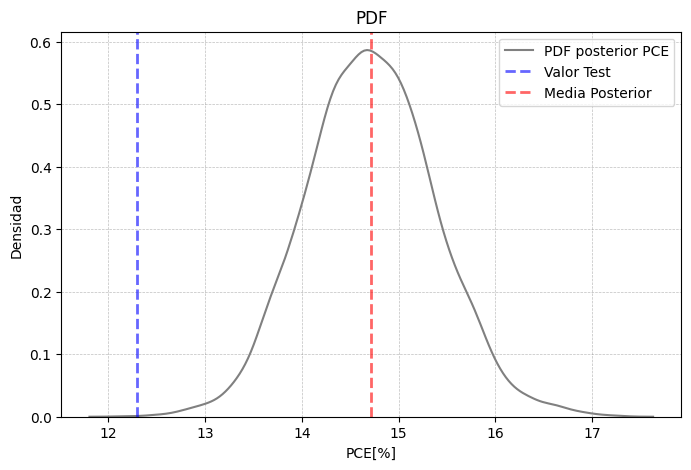

predicciones = 1
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.15, 'DeltaL': 0.3, 'Grain_size': 1.154, 'Thickness': -0.6931471805599453}


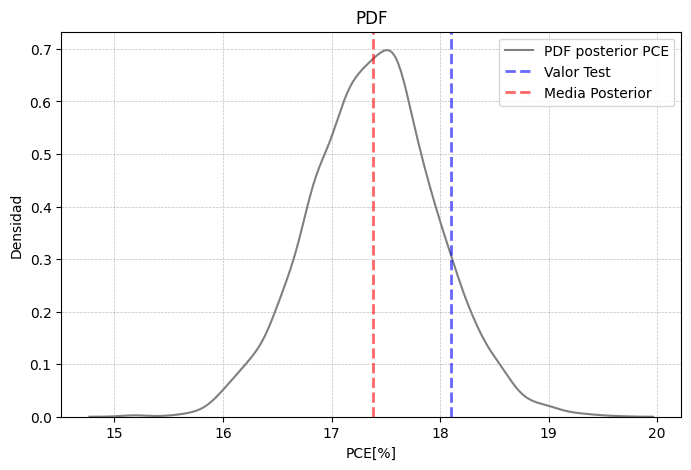

predicciones = 2
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.8, 'Thickness': -0.6931471805599453}


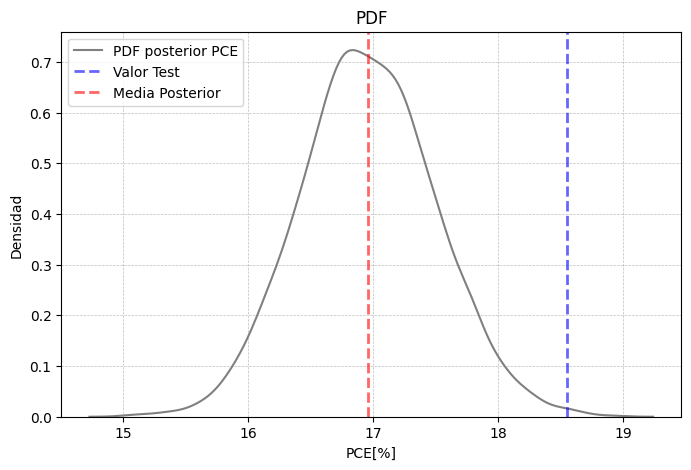

predicciones = 3
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.55, 'Thickness': -1.2039728043259361}


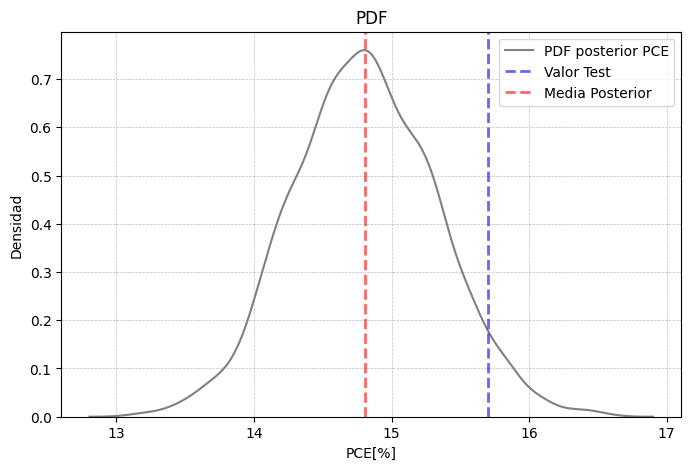

predicciones = 4
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.15, 'DeltaL': 0.2, 'Grain_size': 0.3, 'Thickness': -1.0498221244986778}


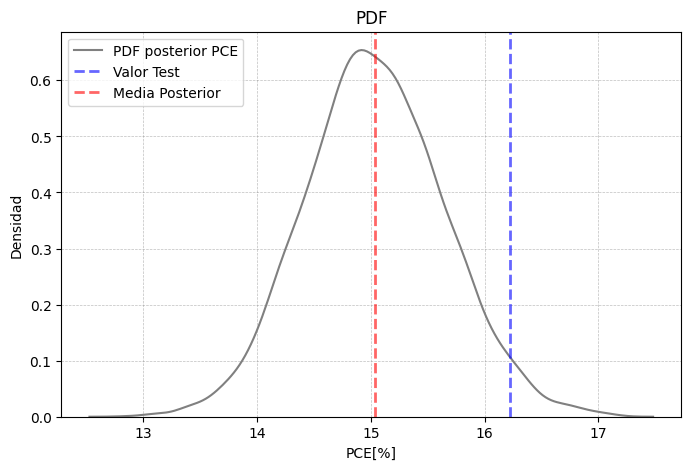

predicciones = 5
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.3, 'Thickness': -1.0498221244986778}


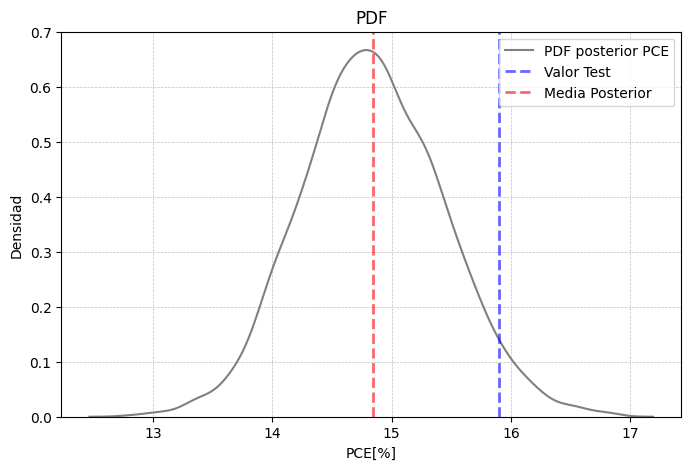

predicciones = 6
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.654, 'Thickness': -1.0498221244986778}


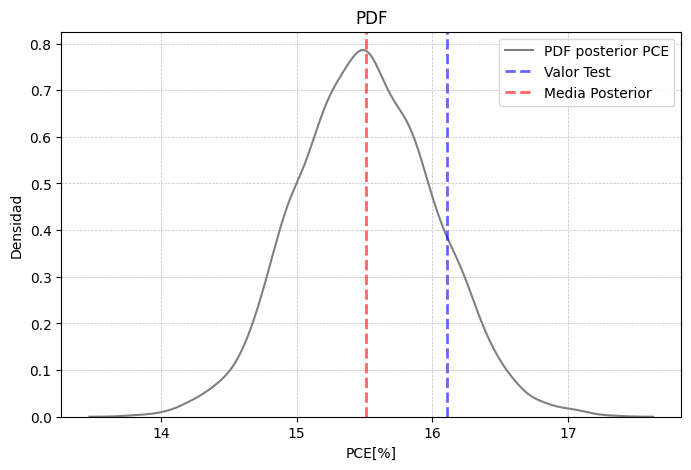

predicciones = 7
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.45, 'Thickness': -0.8915981192837836}


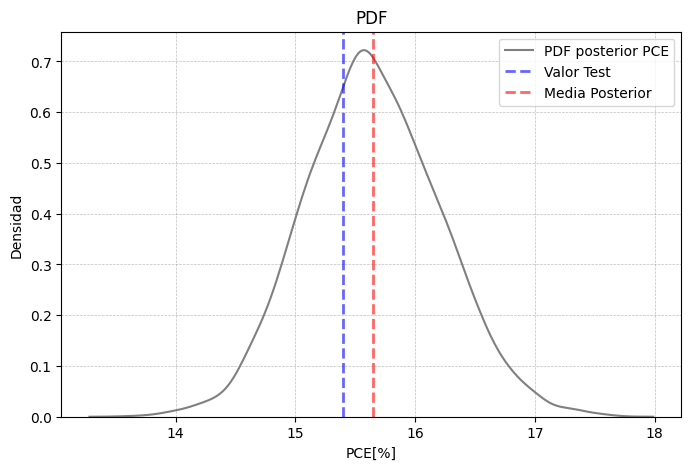

predicciones = 8
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.2, 'DeltaL': 0.0, 'Grain_size': 0.425, 'Thickness': -1.0498221244986778}


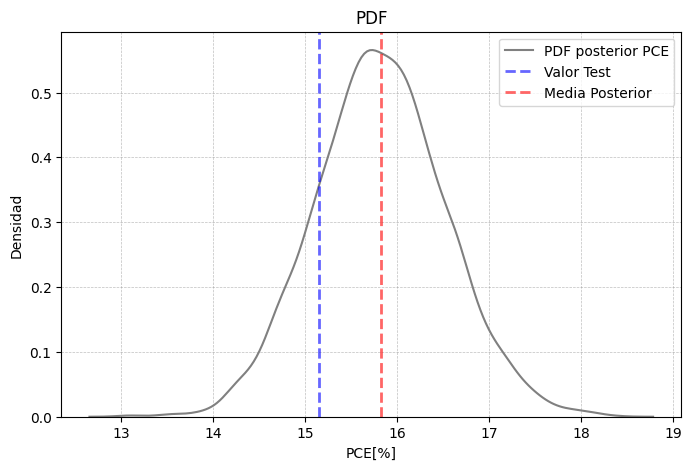

predicciones = 9
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.2, 'DeltaL': 0.3, 'Grain_size': 0.425, 'Thickness': -1.0498221244986778}


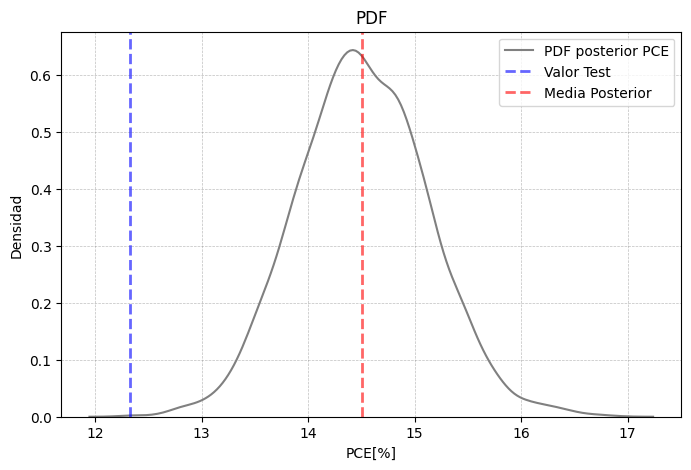

predicciones = 10
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.2, 'DeltaL': 0.3, 'Grain_size': 0.628, 'Thickness': -1.2039728043259361}


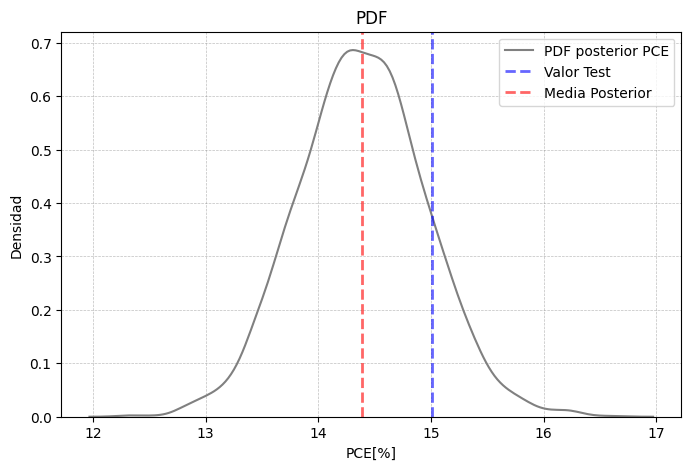

predicciones = 11
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.32, 'Grain_size': 0.5, 'Thickness': -0.5978370007556204}


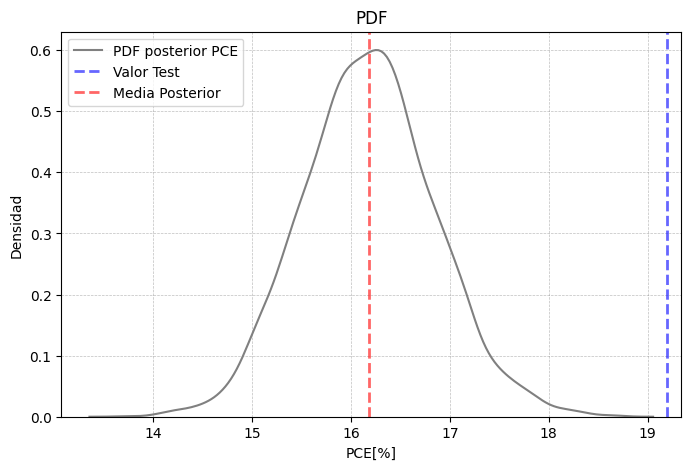

predicciones = 12
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.3, 'Grain_size': 1.097, 'Thickness': -1.2378743560016174}


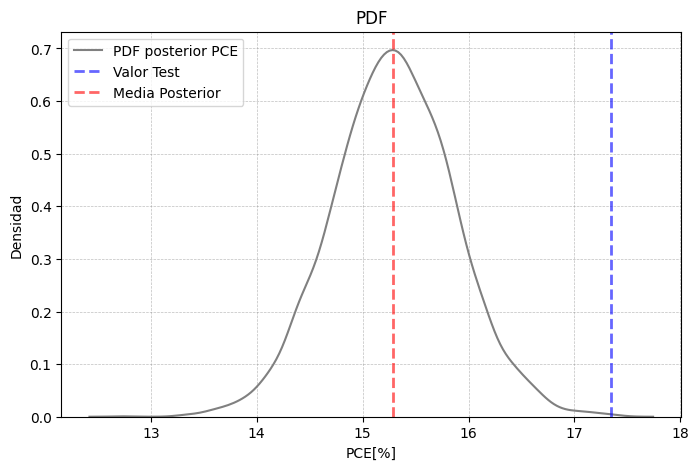

Voc
2-fold
predicciones = 0
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.2, 'DeltaL': 0.3, 'Grain_size': 0.301, 'Thickness': 0.4}


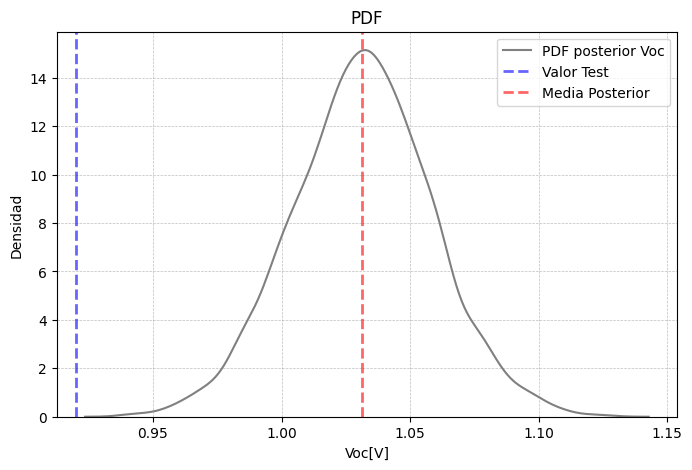

predicciones = 1
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.15, 'DeltaL': 0.3, 'Grain_size': 1.154, 'Thickness': 0.5}


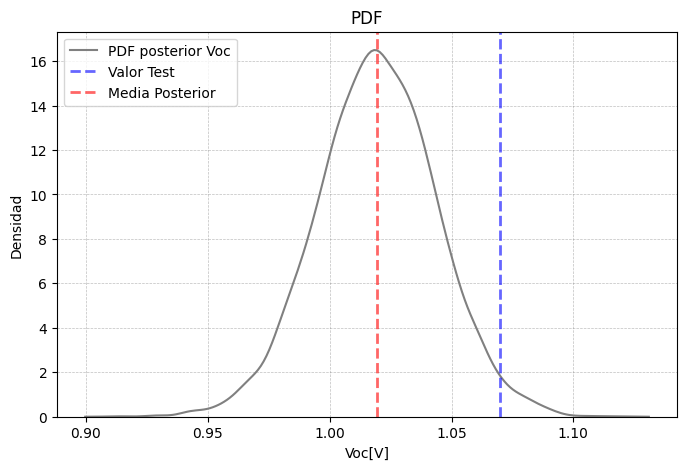

predicciones = 2
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.8, 'Thickness': 0.5}


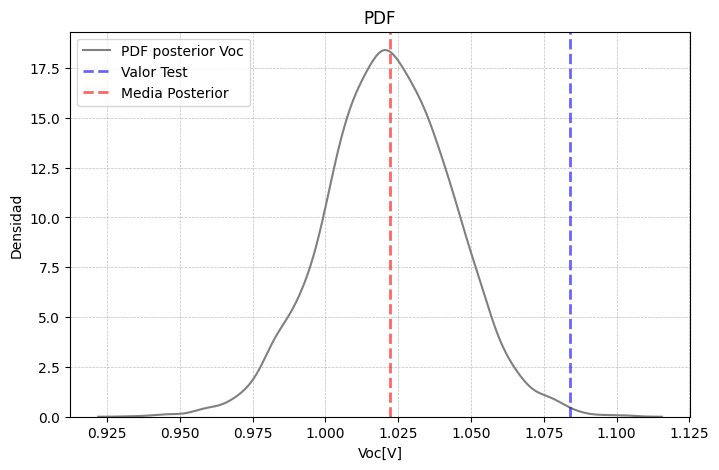

predicciones = 3
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.55, 'Thickness': 0.3}


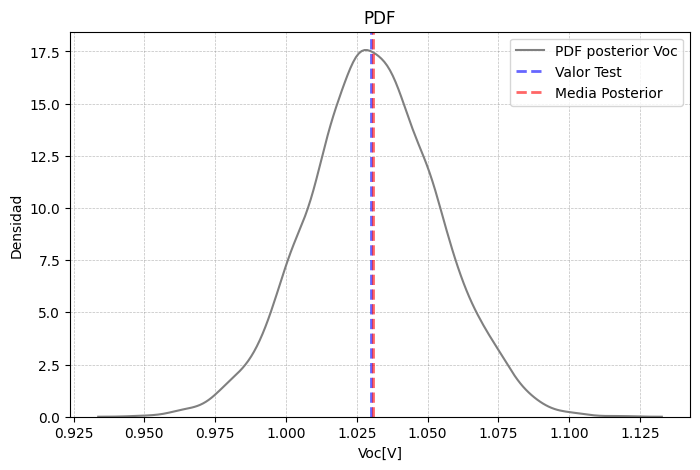

predicciones = 4
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.15, 'DeltaL': 0.2, 'Grain_size': 0.3, 'Thickness': 0.35}


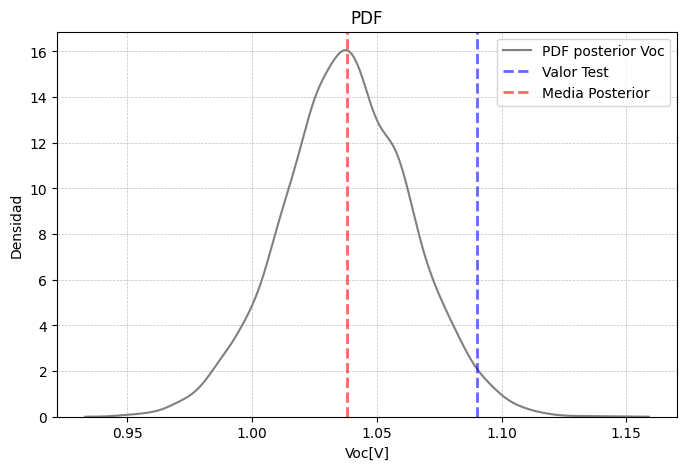

predicciones = 5
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.3, 'Thickness': 0.35}


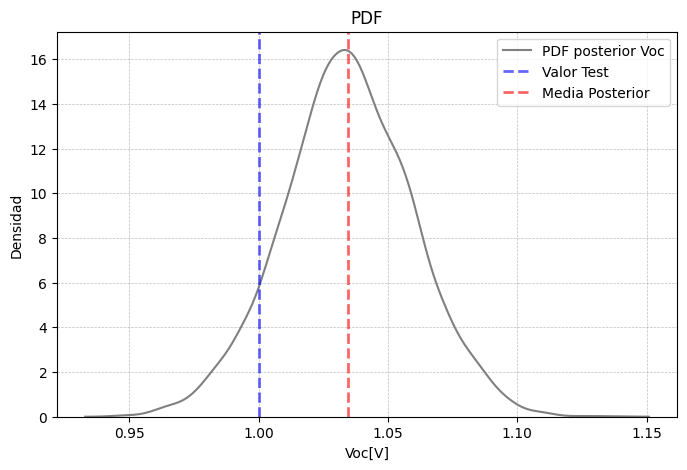

predicciones = 6
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.654, 'Thickness': 0.35}


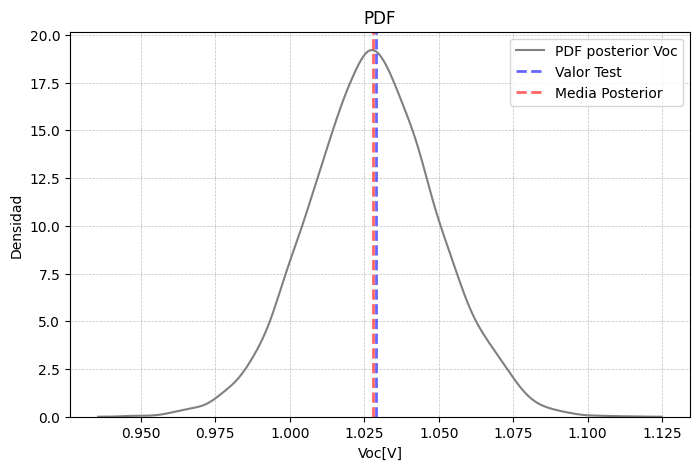

predicciones = 7
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.45, 'Thickness': 0.41}


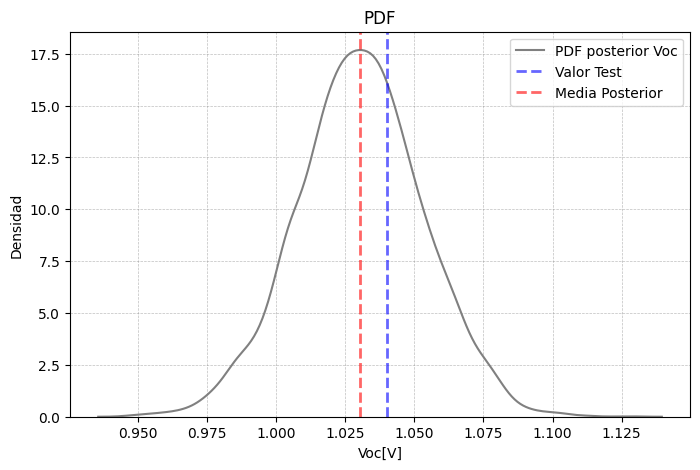

predicciones = 8
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.2, 'DeltaL': 0.0, 'Grain_size': 0.425, 'Thickness': 0.35}


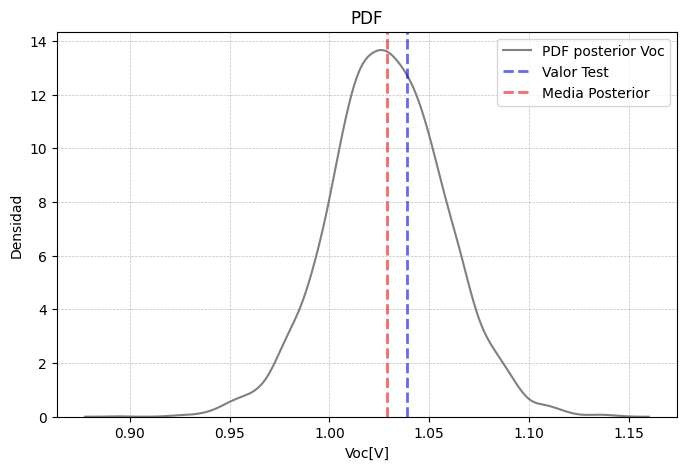

predicciones = 9
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.2, 'DeltaL': 0.3, 'Grain_size': 0.425, 'Thickness': 0.35}


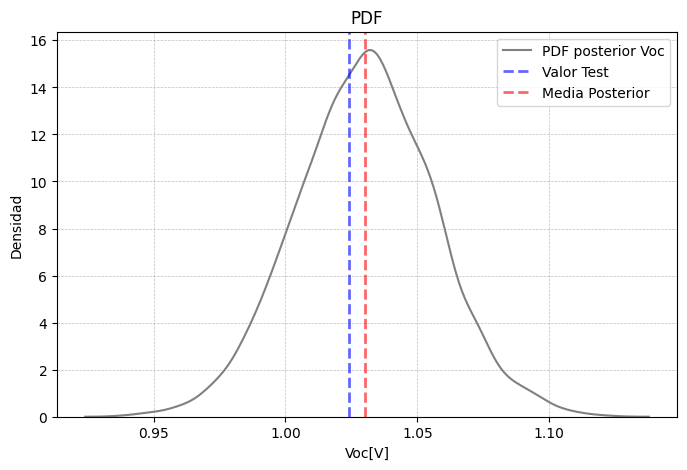

predicciones = 10
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.2, 'DeltaL': 0.3, 'Grain_size': 0.628, 'Thickness': 0.3}


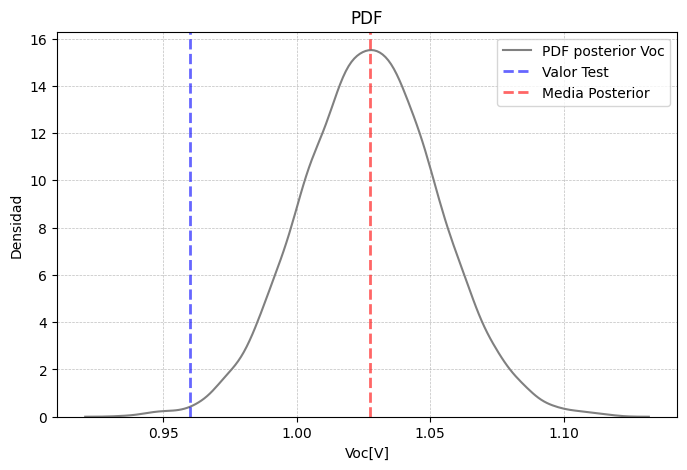

predicciones = 11
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.32, 'Grain_size': 0.5, 'Thickness': 0.55}


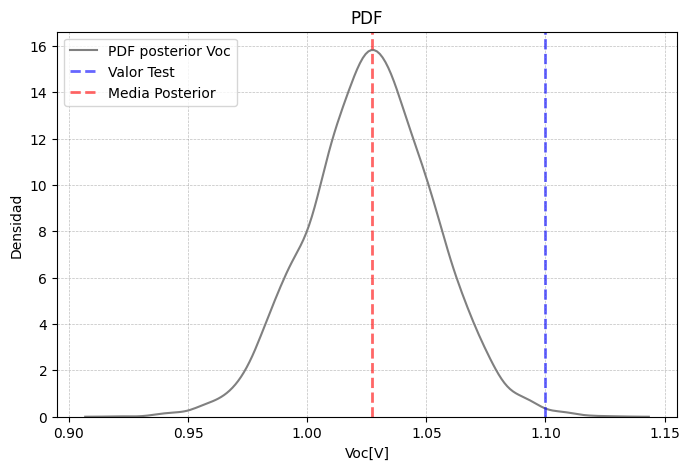

predicciones = 12
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.3, 'Grain_size': 1.097, 'Thickness': 0.29}


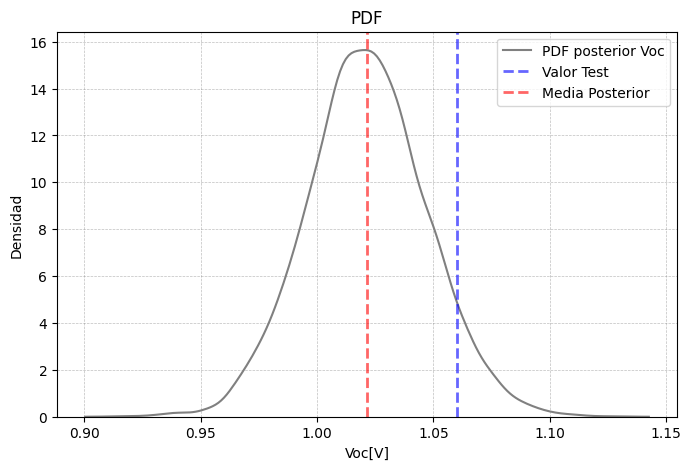

Jsc
2-fold
predicciones = 0
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.2, 'DeltaL': 0.3, 'Grain_size': 0.301, 'Thickness': -0.916290731874155}


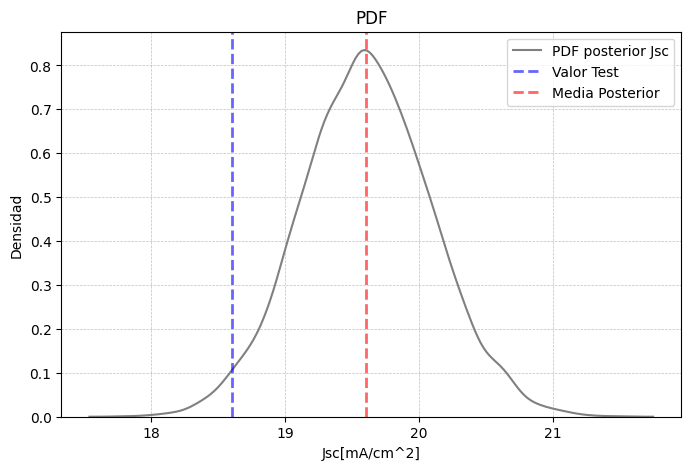

predicciones = 1
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.15, 'DeltaL': 0.3, 'Grain_size': 1.154, 'Thickness': -0.6931471805599453}


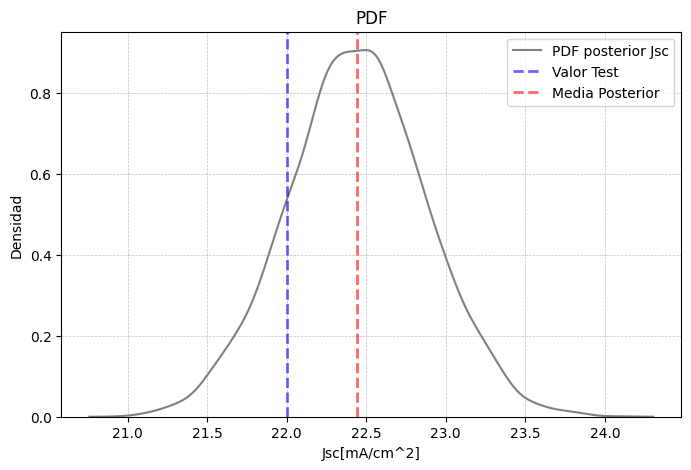

predicciones = 2
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.8, 'Thickness': -0.6931471805599453}


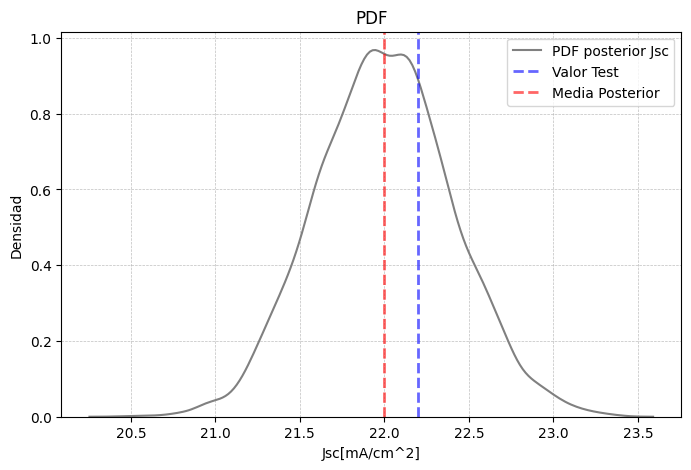

predicciones = 3
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.55, 'Thickness': -1.2039728043259361}


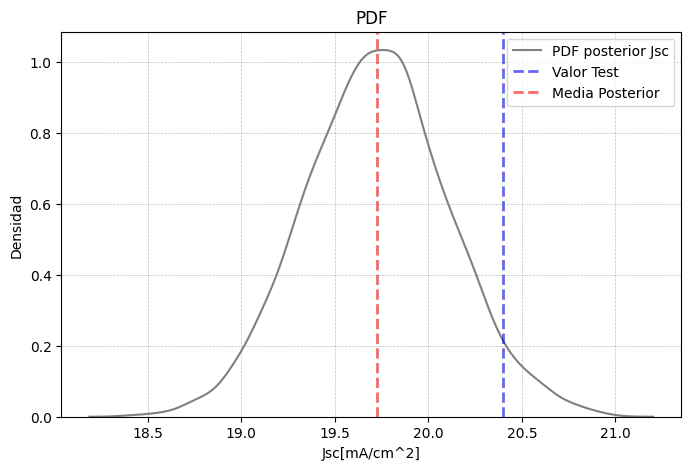

predicciones = 4
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.15, 'DeltaL': 0.2, 'Grain_size': 0.3, 'Thickness': -1.0498221244986778}


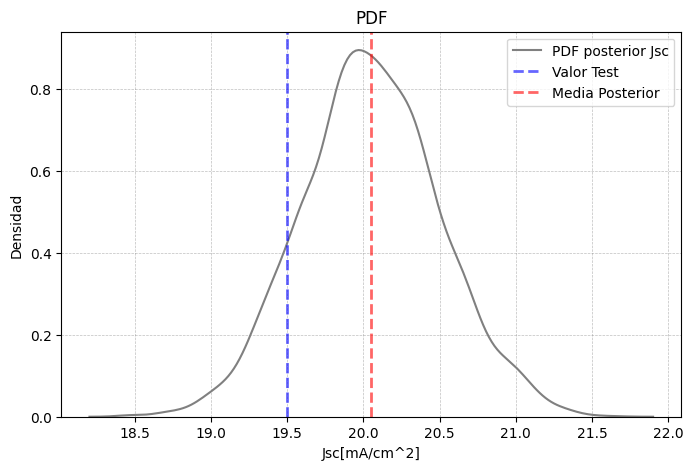

predicciones = 5
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.3, 'Thickness': -1.0498221244986778}


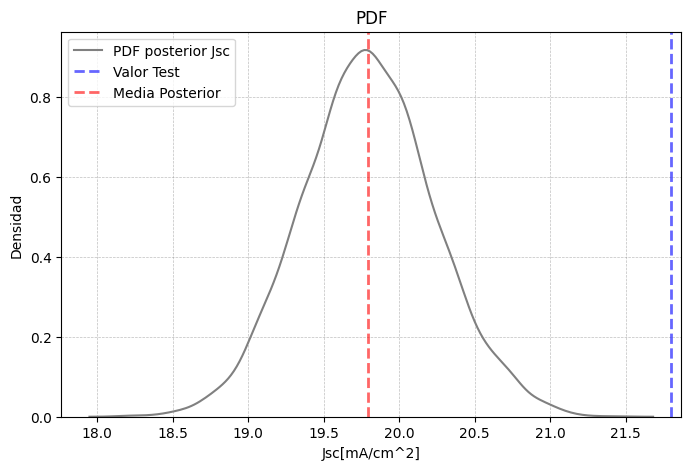

predicciones = 6
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.654, 'Thickness': -1.0498221244986778}


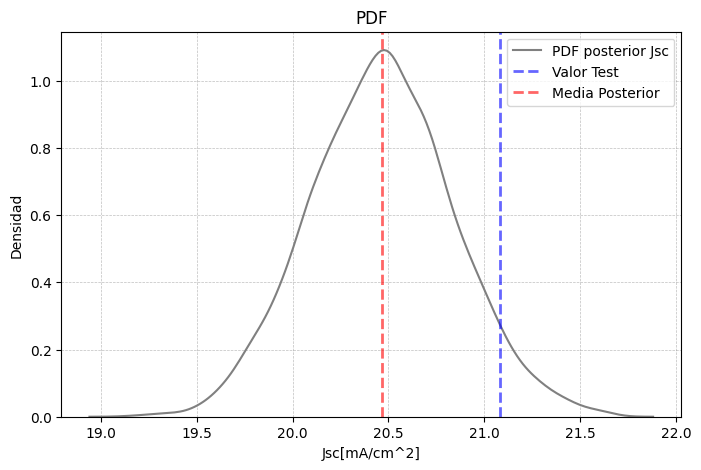

predicciones = 7
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.45, 'Thickness': -0.8915981192837836}


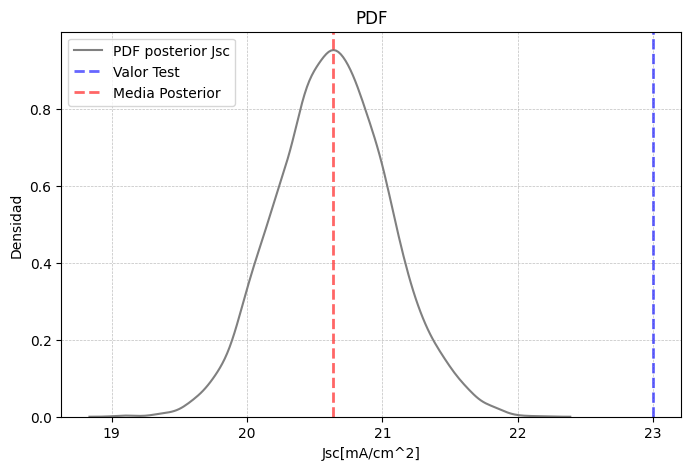

predicciones = 8
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.2, 'DeltaL': 0.0, 'Grain_size': 0.425, 'Thickness': -1.0498221244986778}


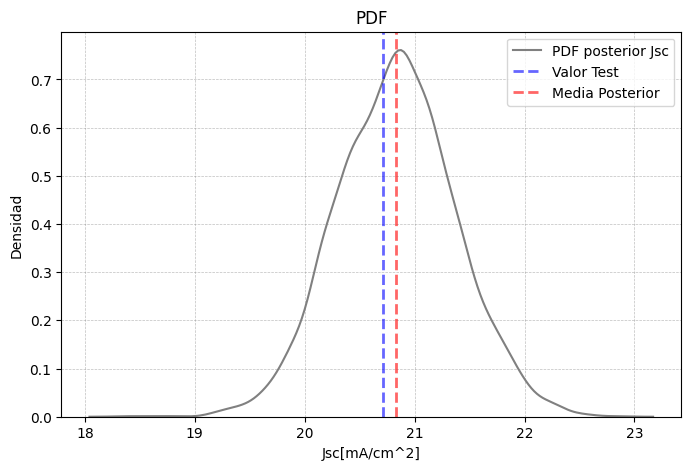

predicciones = 9
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.2, 'DeltaL': 0.3, 'Grain_size': 0.425, 'Thickness': -1.0498221244986778}


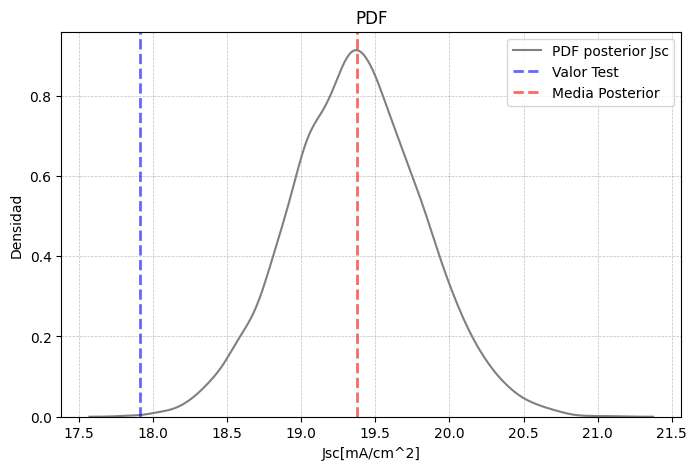

predicciones = 10
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.2, 'DeltaL': 0.3, 'Grain_size': 0.628, 'Thickness': -1.2039728043259361}


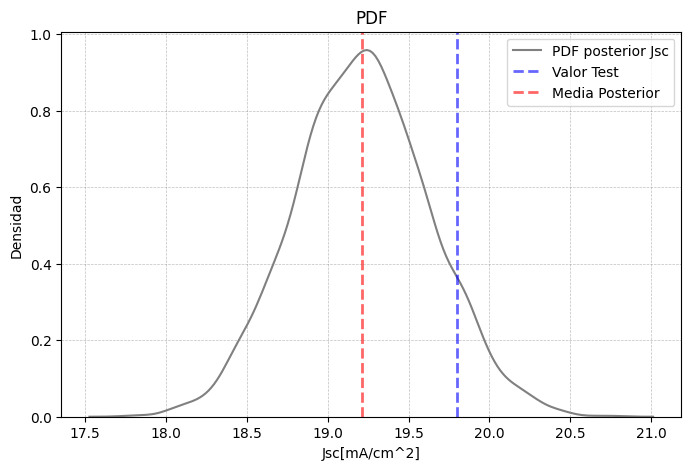

predicciones = 11
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.32, 'Grain_size': 0.5, 'Thickness': -0.5978370007556204}


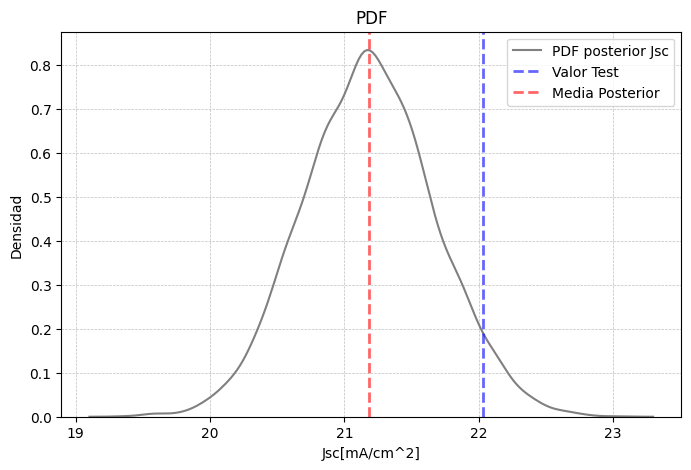

predicciones = 12
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.3, 'Grain_size': 1.097, 'Thickness': -1.2378743560016174}


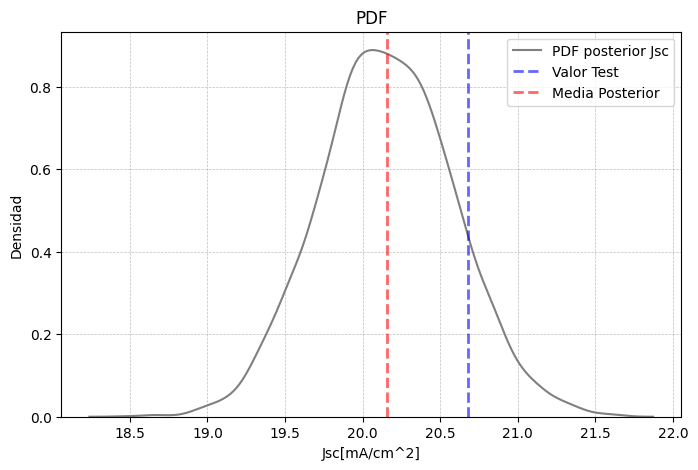

FF
2-fold
predicciones = 0
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.2, 'DeltaL': 0.3, 'Grain_size': 0.301, 'Thickness': 0.4}


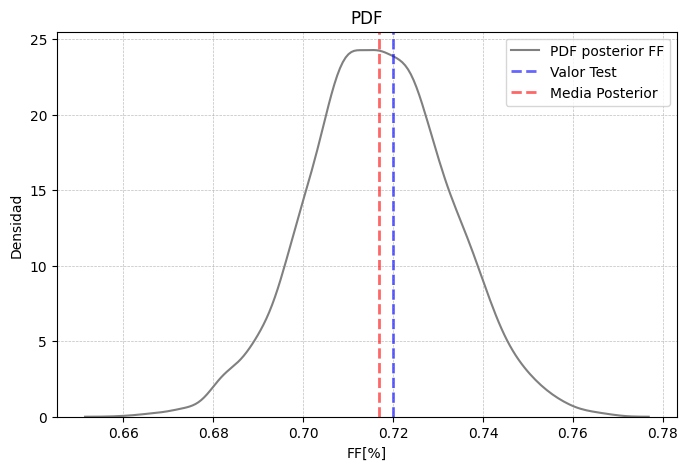

predicciones = 1
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.15, 'DeltaL': 0.3, 'Grain_size': 1.154, 'Thickness': 0.5}


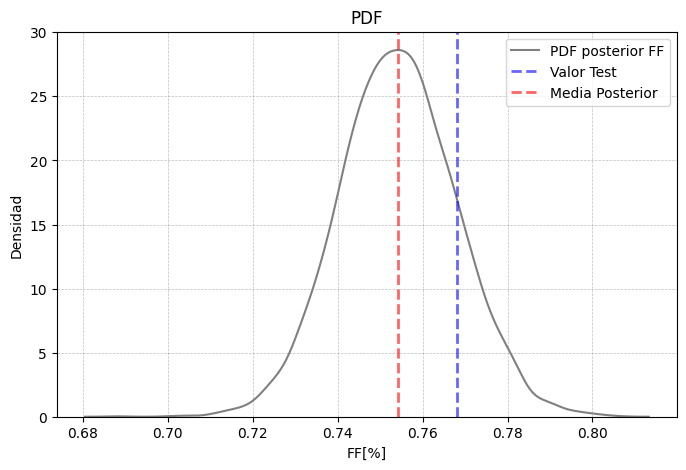

predicciones = 2
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.8, 'Thickness': 0.5}


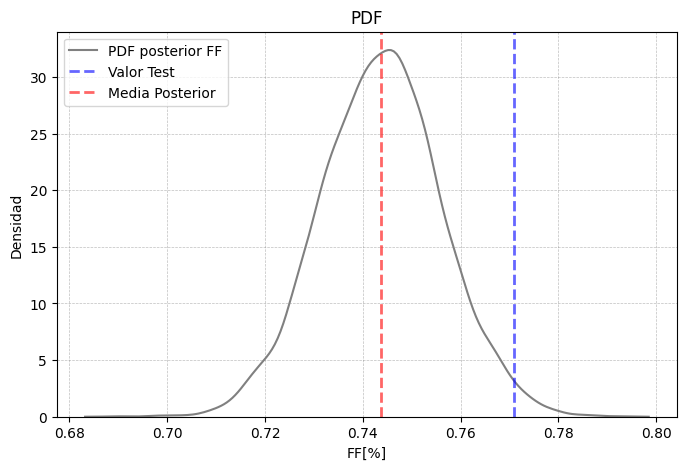

predicciones = 3
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.55, 'Thickness': 0.3}


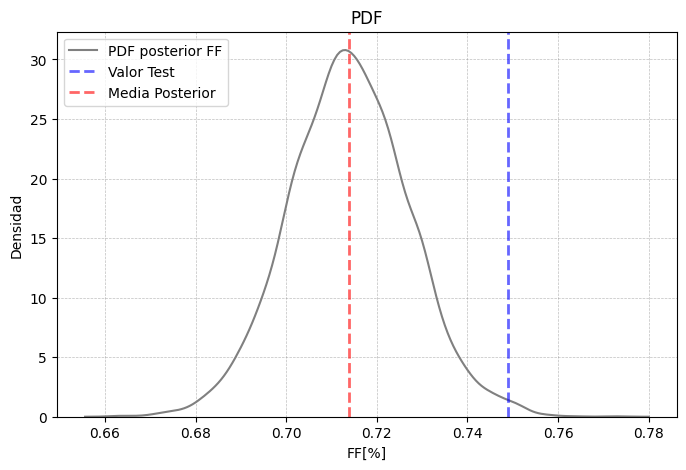

predicciones = 4
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.15, 'DeltaL': 0.2, 'Grain_size': 0.3, 'Thickness': 0.35}


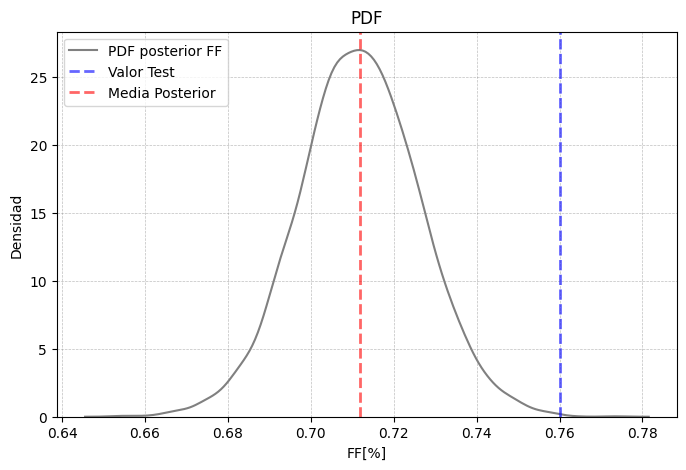

predicciones = 5
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.3, 'Thickness': 0.35}


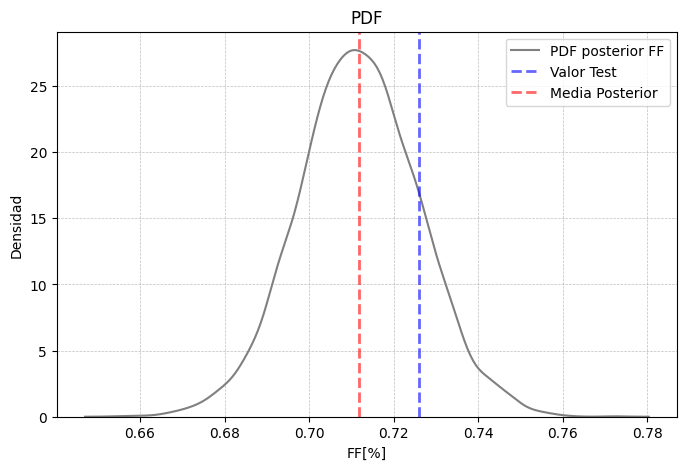

predicciones = 6
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.654, 'Thickness': 0.35}


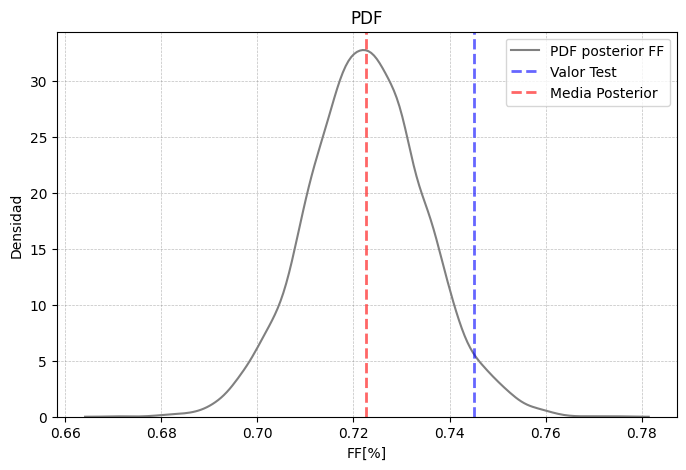

predicciones = 7
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.45, 'Thickness': 0.41}


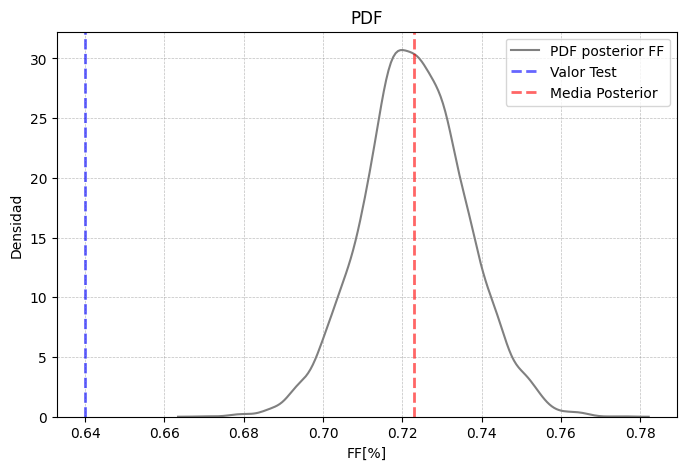

predicciones = 8
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.2, 'DeltaL': 0.0, 'Grain_size': 0.425, 'Thickness': 0.35}


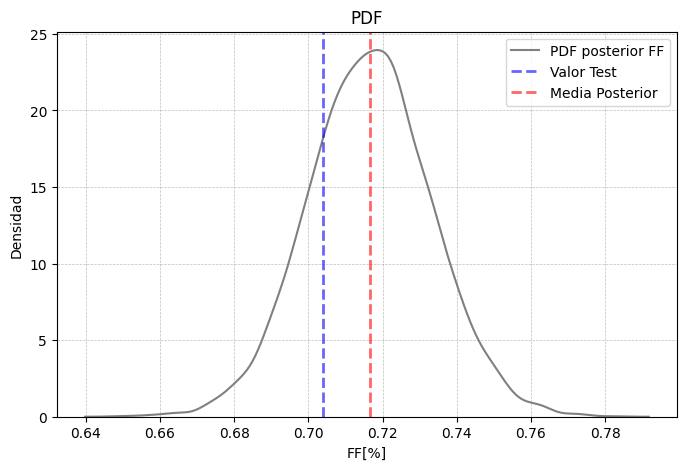

predicciones = 9
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.2, 'DeltaL': 0.3, 'Grain_size': 0.425, 'Thickness': 0.35}


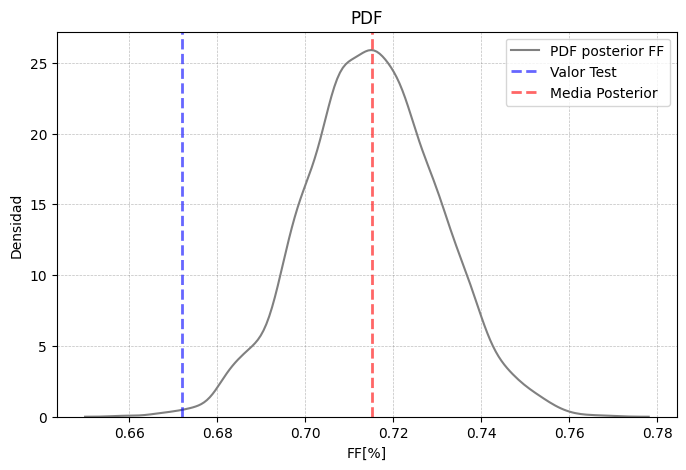

predicciones = 10
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.2, 'DeltaL': 0.3, 'Grain_size': 0.628, 'Thickness': 0.3}


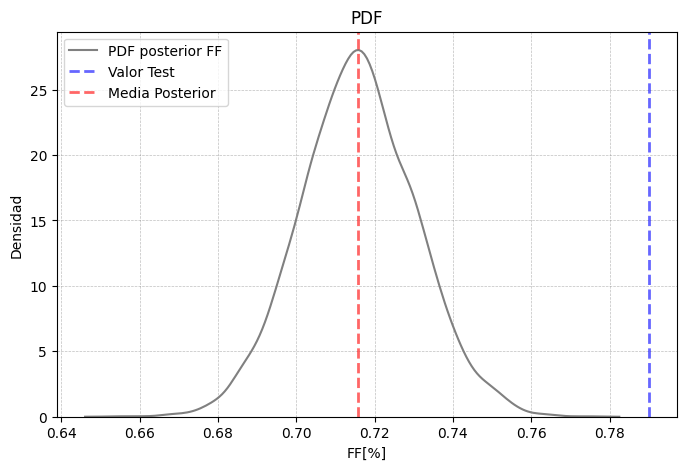

predicciones = 11
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.32, 'Grain_size': 0.5, 'Thickness': 0.55}


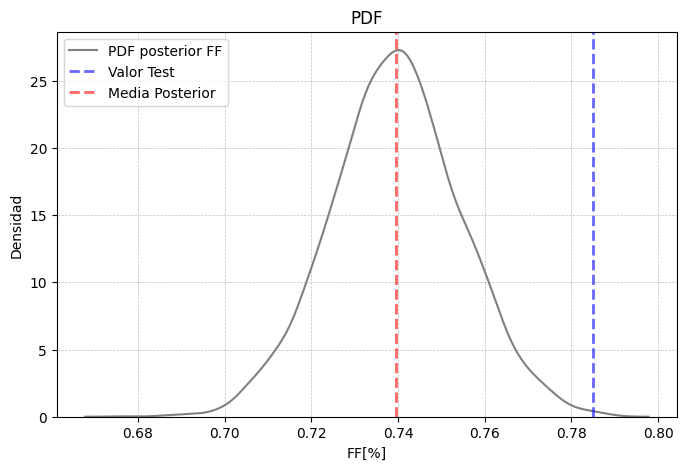

predicciones = 12
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.3, 'Grain_size': 1.097, 'Thickness': 0.29}


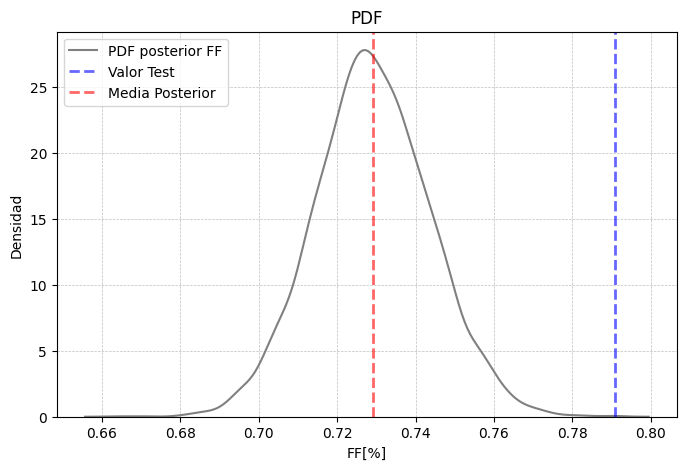

In [ ]:
# PDF de las predicciones (ejemplo)
grid_style = {'color': 'gray', 'linestyle': '--', 'linewidth': 0.5, 'alpha': 0.5}
unidades = {"Band_gap": "eV", "DeltaH": "eV", "DeltaL": "eV", "Grain_size": "mm", "Thickness": "mm", "PCE": "%", "Voc": "V", "Jsc": "mA/cm^2", "FF": "%"}
for datos in data[data.columns[8:]]:
  print(datos)
  for i in range(2,3):
    predicciones = prediccion[f"prediccion_{datos}"][f"fold_{i}"]
    test = (data_test[f'data_test_{datos}'][f'test_fold_{i}']['y_test'])
    x_mean = data_train[f'data_train_{datos}'][f'train_fold_{i}']['x_mean']
    x_std = data_train[f'data_train_{datos}'][f'train_fold_{i}']['x_std']
    x_test = data_test[f'data_test_{datos}'][f'test_fold_{i}']['x_test']
    x_test = (x_test*x_std) + x_mean
    print(f'{i}-fold')
    #print(x_test)
    for j in range(0,len(predicciones)):
      print(f"predicciones = {j}")
      x_test_temporal = {}
      for k in range(len(data.columns[:8])):
        x_test_temporal[data.columns[k]] = x_test[j][k]
      print(x_test_temporal)
      plt.figure(figsize=(8, 5))
      posterior_predictive = sns.kdeplot(predicciones[j], label = f'PDF posterior {datos}', color = "gray")
      plt.axvline(x=test[j], color='b', linestyle='--', linewidth=2, label='Valor Test', alpha = 0.6)
      # Calcular la media de la distribución de densidad posterior
      media_posterior = predicciones[j].mean()
      # Agregar línea vertical para la media de la distribución posterior
      plt.axvline(x=media_posterior, color='r', linestyle='--', linewidth=2, label='Media Posterior', alpha = 0.6)
      plt.xlabel(f"{datos}[{unidades[datos]}]")
      plt.ylabel("Densidad")
      plt.title("PDF")
      plt.legend()
      plt.grid(True, **grid_style)
      plt.show()

## Graficos de intervalo de credibilidad del 90%

PCE
Intervalo de confianza al 0.90: (15.36, 22.53)
min = [11.383606241527605], max = [26.899309741400337]
Valor porcentual HDI frente a la PDF =  46.217008955234974
Intervalo de confianza al 0.90: (13.93, 17.48)
min = [11.383606241527605, 12.170536408133685], max = [26.899309741400337, 19.643123114877426]
Valor porcentual HDI frente a la PDF =  47.526953197081305
Intervalo de confianza al 0.90: (7.39, 19.42)
min = [11.383606241527605, 12.170536408133685, -1.7283970074680113], max = [26.899309741400337, 19.643123114877426, 23.228495404921382]
Valor porcentual HDI frente a la PDF =  48.212265868912155
Intervalo de confianza al 0.90: (15.45, 20.97)
min = [11.383606241527605, 12.170536408133685, -1.7283970074680113, 12.11143709292007], max = [26.899309741400337, 19.643123114877426, 23.228495404921382, 23.75680110740844]
Valor porcentual HDI frente a la PDF =  47.37411363557776
Intervalo de confianza al 0.90: (8.84, 34.59)
min = [11.383606241527605, 12.170536408133685, -1.7283970074680113, 

<Figure size 800x500 with 0 Axes>

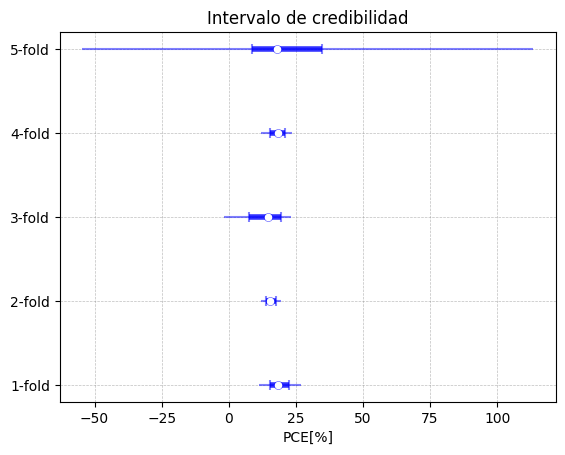

Voc
Intervalo de confianza al 0.90: (0.99, 1.29)
min = [0.7118658676383491], max = [1.4643735971297456]
Valor porcentual HDI frente a la PDF =  40.53510420309562
Intervalo de confianza al 0.90: (0.99, 1.07)
min = [0.7118658676383491, 0.8935036160115108], max = [1.4643735971297456, 1.1448890755394359]
Valor porcentual HDI frente a la PDF =  33.58776106130064
Intervalo de confianza al 0.90: (0.91, 1.13)
min = [0.7118658676383491, 0.8935036160115108, 0.6107450651708037], max = [1.4643735971297456, 1.1448890755394359, 1.311336798769946]
Valor porcentual HDI frente a la PDF =  32.09153284703088
Intervalo de confianza al 0.90: (0.96, 1.12)
min = [0.7118658676383491, 0.8935036160115108, 0.6107450651708037, 0.8542721039674805], max = [1.4643735971297456, 1.1448890755394359, 1.311336798769946, 1.2669895711125807]
Valor porcentual HDI frente a la PDF =  39.7494539046993
Intervalo de confianza al 0.90: (0.91, 1.40)
min = [0.7118658676383491, 0.8935036160115108, 0.6107450651708037, 0.8542721039674

<Figure size 800x500 with 0 Axes>

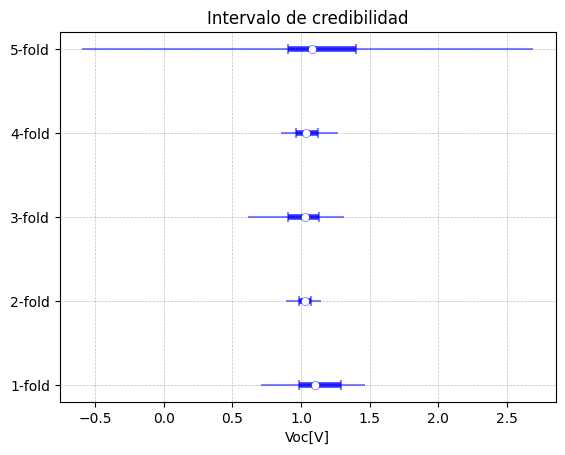

Jsc
Intervalo de confianza al 0.90: (19.40, 26.41)
min = [17.000219173020376], max = [28.356765025917362]
Valor porcentual HDI frente a la PDF =  61.80546836366072
Intervalo de confianza al 0.90: (18.98, 22.43)
min = [17.000219173020376, 17.756865927008985], max = [28.356765025917362, 24.065563483959913]
Valor porcentual HDI frente a la PDF =  54.689612258432554
Intervalo de confianza al 0.90: (14.73, 23.06)
min = [17.000219173020376, 17.756865927008985, 10.180474361602272], max = [28.356765025917362, 24.065563483959913, 26.087186545089935]
Valor porcentual HDI frente a la PDF =  52.38801118489735
Intervalo de confianza al 0.90: (20.30, 25.86)
min = [17.000219173020376, 17.756865927008985, 10.180474361602272, 17.05040324435542], max = [28.356765025917362, 24.065563483959913, 26.087186545089935, 28.63763016387183]
Valor porcentual HDI frente a la PDF =  48.00603416507167
Intervalo de confianza al 0.90: (13.42, 71.85)
min = [17.000219173020376, 17.756865927008985, 10.180474361602272, 17.

<Figure size 800x500 with 0 Axes>

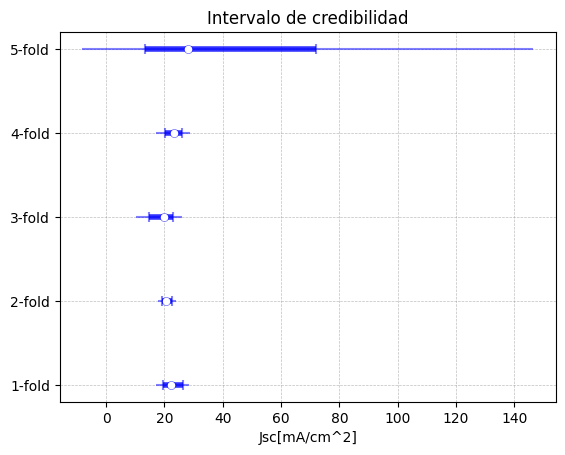

FF
Intervalo de confianza al 0.90: (0.70, 0.82)
min = [0.5814110863506132], max = [0.9750886193860133]
Valor porcentual HDI frente a la PDF =  29.892837779407415
Intervalo de confianza al 0.90: (0.69, 0.76)
min = [0.5814110863506132, 0.6488851553355295], max = [0.9750886193860133, 0.8057323930392555]
Valor porcentual HDI frente a la PDF =  40.69883738747554
Intervalo de confianza al 0.90: (0.63, 0.81)
min = [0.5814110863506132, 0.6488851553355295, 0.5230387438268277], max = [0.9750886193860133, 0.8057323930392555, 0.9778637200726554]
Valor porcentual HDI frente a la PDF =  38.46501504048672
Intervalo de confianza al 0.90: (0.70, 0.76)
min = [0.5814110863506132, 0.6488851553355295, 0.5230387438268277, 0.6473750706941978], max = [0.9750886193860133, 0.8057323930392555, 0.9778637200726554, 0.8210127577705929]
Valor porcentual HDI frente a la PDF =  37.145297761723846
Intervalo de confianza al 0.90: (0.45, 0.93)
min = [0.5814110863506132, 0.6488851553355295, 0.5230387438268277, 0.647375070

<Figure size 800x500 with 0 Axes>

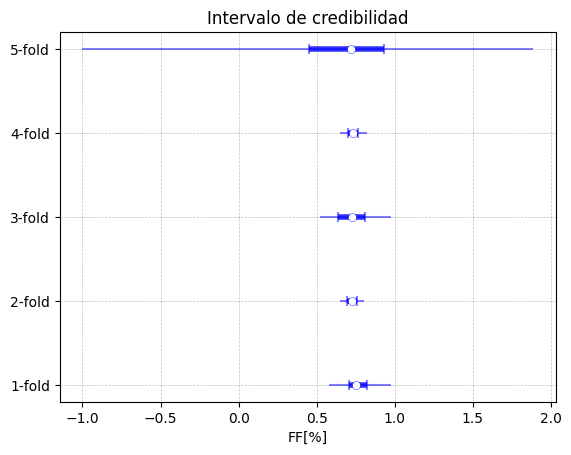

In [ ]:
alpha = 0.1
fold = ["1-fold", "2-fold", "3-fold", "4-fold", "5-fold"]
for datos in data[data.columns[8:]]:
  print(datos)
  ci_low = []
  ci_upper = []
  mean = []
  min = []
  max = []
  for i in range(1,6):
    lower_bound = np.percentile(prediccion[f"prediccion_{datos}"][f"fold_{i}"], alpha/2 * 100)
    upper_bound = np.percentile(prediccion[f"prediccion_{datos}"][f"fold_{i}"], (1 - alpha/2) * 100)
    min_ = np.min(prediccion[f"prediccion_{datos}"][f"fold_{i}"])
    max_ = np.max(prediccion[f"prediccion_{datos}"][f"fold_{i}"])
    min.append(np.min(prediccion[f"prediccion_{datos}"][f"fold_{i}"]))
    max.append(np.max(prediccion[f"prediccion_{datos}"][f"fold_{i}"]))
    ci_low.append(lower_bound)
    ci_upper.append(upper_bound)
    mean.append(np.mean(prediccion[f"prediccion_{datos}"][f"fold_{i}"]))
    print(f"Intervalo de confianza al {1-alpha:.2f}: ({lower_bound:.2f}, {upper_bound:.2f})")
    print(f"min = {min}, max = {max}")
    porcentaje_hdi = (upper_bound-lower_bound)/(max_-min_)*100
    print('Valor porcentual HDI frente a la PDF = ', porcentaje_hdi)
  # Crear un arreglo de posiciones para las barras horizontales
  positions = np.arange(len(fold))
  # Crear la figura y los ejes
  plt.figure(figsize=(8, 5))
  fig, ax = plt.subplots()
  # Dibujar las barras horizontales principales
  ax.hlines(positions, min, max, colors='b', alpha=0.5, linewidth=1.5)
  # Dibujar las barras horizontales secundarias
  ax.hlines(positions, ci_low, ci_upper, colors='b', alpha=0.8, linewidth=4)

  # Dibujar los puntos de estimación puntual
  ax.scatter(mean, positions, color='blue', marker='o', s = 30, zorder=10, alpha = 0.5)
  ax.scatter(mean, positions, color='white', marker='o', s = 20, zorder=10, alpha = 1)
  ax.scatter(ci_low, positions, color='blue', marker='|', s = 50, zorder=10, alpha = 0.5)
  ax.scatter(ci_upper, positions, color='blue', marker='|', s = 50, zorder=10, alpha = 0.5)
  # Etiquetas de los ejes
  ax.set_yticks(positions)
  ax.set_yticklabels(fold)
  ax.set_xlabel(f'{datos}[{unidades[datos]}]')
  #ax.set_ylabel('Parámetros')
  # Título del gráfico
  ax.set_title(f'Intervalo de credibilidad')
  # Mostrar el gráfico
  ruta = '/content/drive/My Drive/Deep Learning/TG/Imagenes/Regression/HDI/'
  plt.grid(True, **grid_style)
  plt.savefig(ruta + f'{datos}.png')
  plt.show()

## Grafico de relacion entre estimaciones y datos reales

PCE


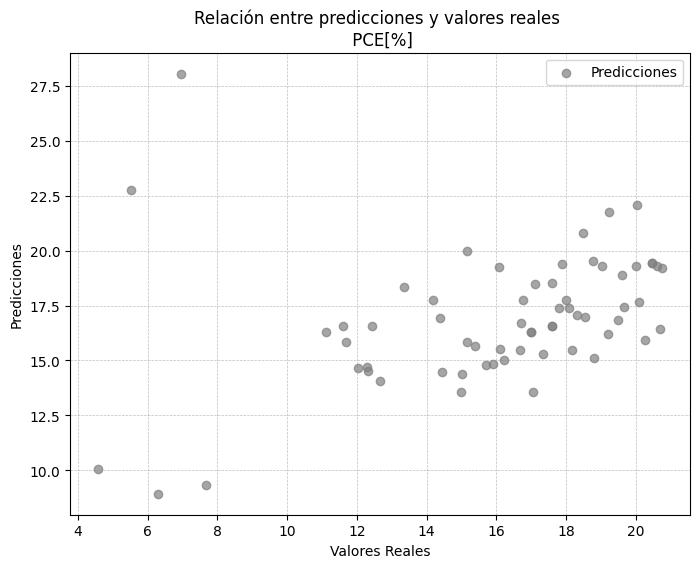

Voc


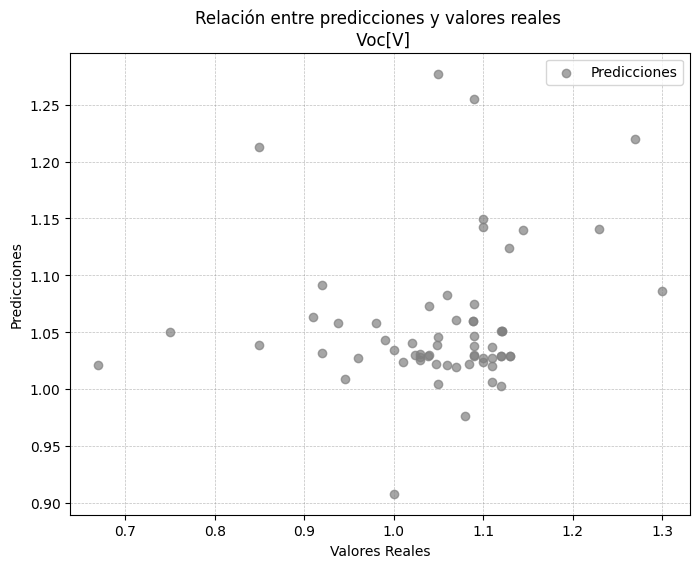

Jsc


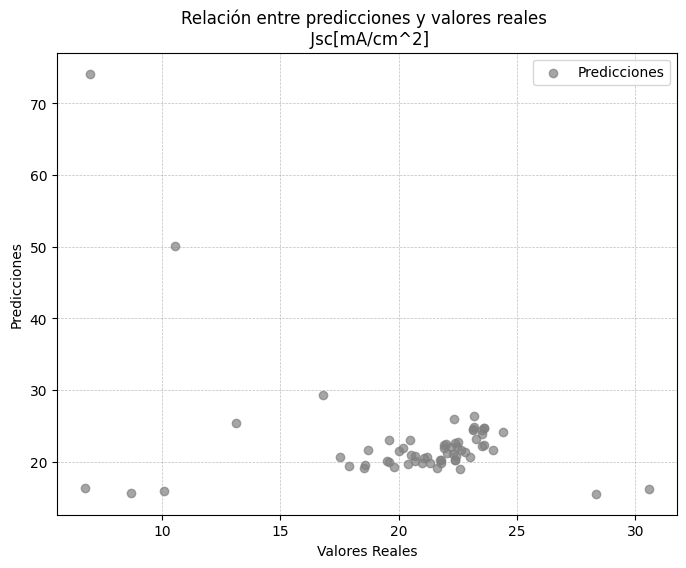

FF


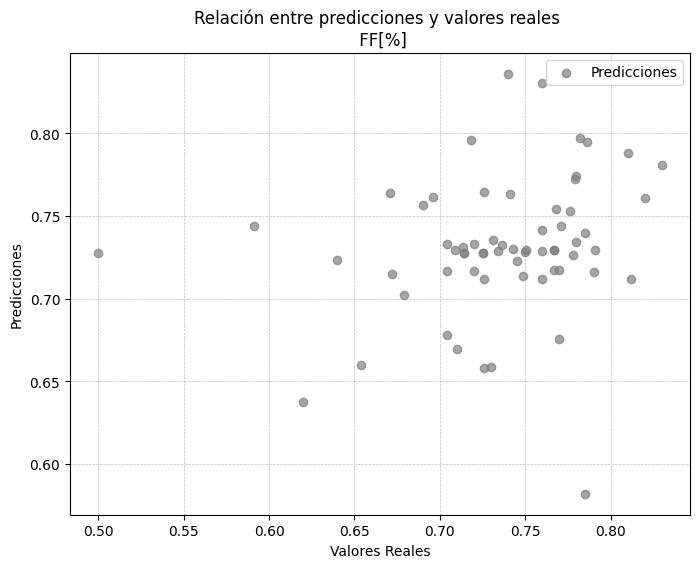

In [ ]:
ruta = '/content/drive/My Drive/Deep Learning/TG/Imagenes/Regression/CorrelacionPvR/'
for datos in data[data.columns[8:]]:
  print(datos)
  predicciones = []
  valor_real = []
  for i in range(1,6):
    predicciones.append(prediccion_mean[f"prediccion_{datos}"][f"fold_{i}"])
    valor_real.append(data_test[f'data_test_{datos}'][f'test_fold_{i}']['y_test'])
  valores_predichos = np.concatenate(predicciones)
  valores_reales = np.concatenate(valor_real)
  plt.figure(figsize=(8, 6))
  plt.scatter(valores_reales, valores_predichos, label='Predicciones', color='gray', alpha = 0.7)
  plt.xlabel(f'Valores Reales')
  plt.ylabel('Predicciones')
  plt.title(f'Relación entre predicciones y valores reales \n {datos}[{unidades[datos]}]')
  plt.legend()
  plt.grid(True, **grid_style)
  # Guarda la figura en un archivo (por ejemplo, en formato PNG) en la carpeta de Drive
  plt.savefig(ruta + f'{datos}.png')
  plt.show()

## Grafico de comparacion de estimaciones vs datos reales

PCE
[16.42490373 17.67353157 17.74345368 16.29401719 19.29848963 20.78376346
 20.00426425 16.57061465 16.57061465 16.27649419 16.27649419 22.06490652
 21.77564854]
[14.71552873 17.38576741 16.95863618 14.8059607  15.0363937  14.84109022
 15.50949016 15.64487535 15.82004921 14.51033262 14.38646074 16.18188413
 15.29066079]
[16.91588352 13.54706646 18.35317339 15.46531736 19.21517055 16.85714429
  9.33747048 10.04897004  8.92849191 17.4260825  14.47589851 15.11748607
 16.58363224]
[16.58104381 15.8468861  19.45150946 19.45150946 19.29294683 19.29294683
 18.88631361 17.05646411 19.53079077 19.37222814 17.76807225 16.70066004]
[14.63565876 17.36837019 18.48461565 18.51620903 14.07946658 22.74161813
 15.92358177 15.45717893 17.76765056 13.56124121 19.23368213 28.06029072]


<Figure size 800x500 with 0 Axes>

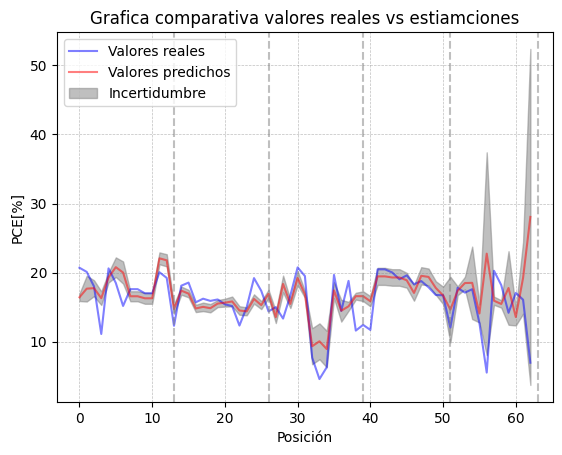

Voc
[1.02715307 1.02571188 1.09131259 1.0087932  1.13981959 1.25535343
 1.27734024 1.05948625 1.05948625 1.05100248 1.05100248 1.14268006
 1.14988685]
[1.03146166 1.01940543 1.02204557 1.03086076 1.03781595 1.03439072
 1.02789552 1.03037006 1.02895409 1.03024355 1.02757595 1.02700871
 1.02146563]
[1.04301437 1.04063525 1.05845696 1.02196594 1.12435971 1.02006614
 1.04589459 1.07269264 1.02370307 0.97629403 0.90791825 1.00281591
 1.03844534]
[1.03888167 1.00610616 1.02934862 1.02934862 1.02878817 1.02878817
 1.03723126 1.07522521 1.02962884 1.02906839 1.06044978 1.08261292]
[1.08609005 1.02375641 1.0047454  1.05027116 1.06354997 1.21303989
 1.05136024 1.04631589 1.02154863 1.05794515 1.14049189 1.22023453]


<Figure size 800x500 with 0 Axes>

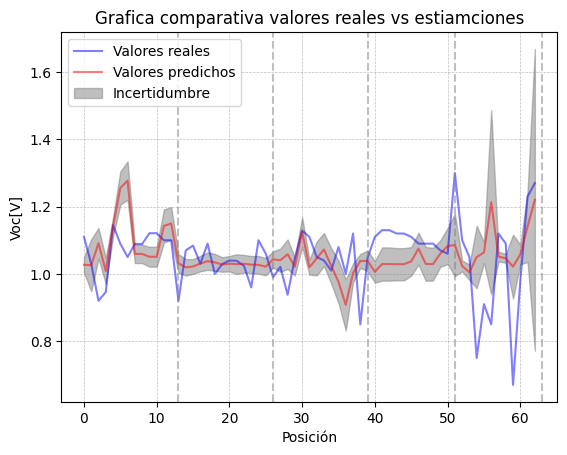

Jsc
[21.58561161 22.13763185 22.59602968 20.60543197 23.23269655 24.09815465
 22.99223786 20.20459065 20.20459065 19.80763693 19.80763693 26.3199918
 25.88998773]
[19.60850448 22.44271703 22.00089952 19.72423075 20.05000772 19.79342096
 20.46547192 20.63636039 20.83330967 19.37284903 19.21443172 21.18340944
 20.15626653]
[21.94109    19.1179701  22.98844661 20.64228778 22.2977868  21.61419303
 15.86908996 16.40722079 15.60589692 22.10779979 19.07247418 20.29578764
 21.57568834]
[21.50395638 20.91246297 24.69563301 24.69563301 24.49198152 24.49198152
 23.91691562 21.32911908 24.79745876 24.59380726 22.3354844  20.82593642]
[25.40470991 21.85512356 22.73159804 16.19244149 19.89770975 50.11037657
 21.0626853  20.27527543 15.53990873 19.02280989 29.27520087 74.10465455]


<Figure size 800x500 with 0 Axes>

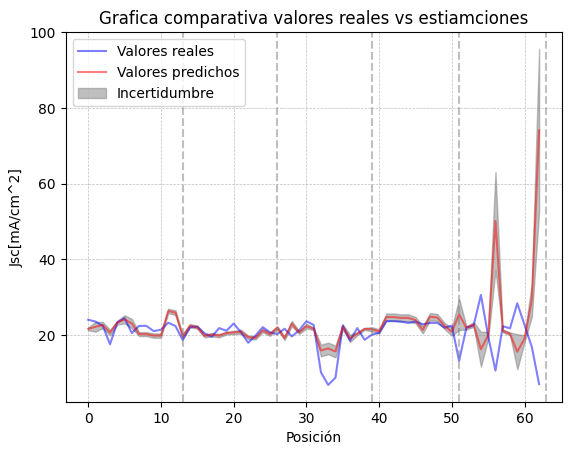

FF
[0.73427665 0.78077885 0.76105739 0.76353433 0.74152617 0.76157719
 0.75666439 0.72774454 0.72774454 0.72779934 0.72779934 0.79484311
 0.79685892]
[0.7168871  0.75414832 0.74377302 0.71387921 0.71177451 0.71177425
 0.72262468 0.72304121 0.71655622 0.71513005 0.71579442 0.73956503
 0.72905833]
[0.73275715 0.70212615 0.76458452 0.72841974 0.77200222 0.75291239
 0.65858989 0.65991138 0.65813743 0.78813314 0.77433893 0.7171693
 0.73530474]
[0.74400392 0.72774205 0.72941356 0.72941356 0.72884128 0.72884128
 0.7294814  0.73236192 0.7296997  0.72912742 0.73124172 0.73292202]
[0.67821351 0.7631715  0.79616243 0.83041368 0.6692897  0.63761895
 0.71191561 0.71742683 0.83593857 0.67541328 0.72652888 0.58198766]


<Figure size 800x500 with 0 Axes>

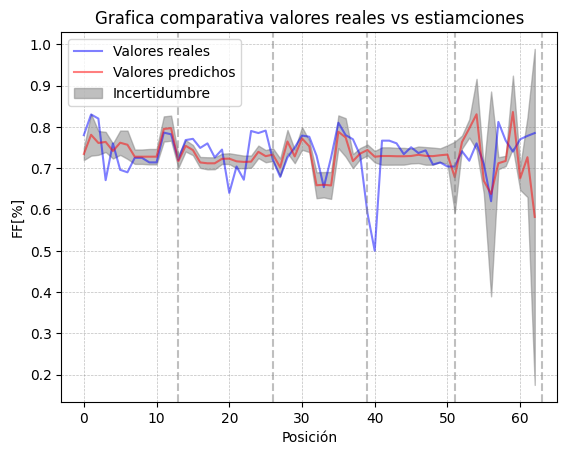

In [ ]:
# Especifica la ruta de la carpeta en Google Drive donde deseas guardar la imagen
ruta = '/content/drive/My Drive/Deep Learning/TG/Imagenes/Regression/Comportamiento_predicciones/'
for datos in data[data.columns[8:]]:
  print(datos)
  predicciones = []
  desviaciones_std = []
  valor_real = []
  posiciones = []
  for i in range(1,6):
    predicciones.append(prediccion_mean[f"prediccion_{datos}"][f"fold_{i}"])
    desviaciones_std.append(desviacion_std[f"desviacion_std_{datos}"][f"fold_{i}"])
    print(prediccion_mean[f"prediccion_{datos}"][f"fold_{i}"])
    posiciones.append(len(prediccion_mean[f"prediccion_{datos}"][f"fold_{i}"]))
    valor_real.append(data_test[f'data_test_{datos}'][f'test_fold_{i}']['y_test'])
  valores_predichos = np.concatenate(predicciones)
  desviaciones_std = np.concatenate(desviaciones_std)
  valor_superior = np.array(valores_predichos) + np.array(desviaciones_std)
  valor_inferior = np.array(valores_predichos) - np.array(desviaciones_std)
  valores_reales = np.concatenate(valor_real)
  x = np.arange(len(valores_predichos))
  # Crear la figura y los ejes
  plt.figure(figsize=(8, 5))
  fig, ax = plt.subplots()

  # Graficar los valores en función de las posiciones con colores diferentes
  ax.plot(x, valores_reales, color='blue', linestyle='-', label='Valores reales', alpha = 0.5)
  ax.plot(x, valores_predichos, color='red', linestyle='-', label='Valores predichos', alpha = 0.5)
  ax.fill_between(x, valor_superior, valor_inferior, color='gray', alpha=0.5, label='Incertidumbre')
  nueva_posicion = 0
  for posicion in posiciones:
    nueva_posicion = posicion + nueva_posicion
    ax.axvline(x=nueva_posicion, color='gray', linestyle='--', alpha = 0.5)
  # Etiquetas de los ejes
  ax.set_xlabel('Posición')
  ax.set_ylabel(f'{datos}[{unidades[datos]}]')
  # Título de la gráfica
  ax.set_title(f'Grafica comparativa valores reales vs estiamciones')
  # Leyenda
  ax.legend()
  plt.grid(True, **grid_style)
  # Guarda la figura en un archivo (por ejemplo, en formato PNG) en la carpeta de Drive
  plt.savefig(ruta + f'{datos}.png')
  # Mostrar la gráfica
  plt.show()

## Grafico de densidad conjunta de las predicciones vs los datos reales

In [ ]:
#for datos in data[data.columns[3:]]:
#  print(datos)
#  predicciones = []
#  valor_real = []
#  for i in range(1,6):
#    predicciones.append(prediccion_mean[f"prediccion_{datos}"][f"fold_{i}"])
#    valor_real.append(data_test[f'data_test_{datos}'][f'test_fold_{i}']['y_test'])
#  valores_predichos = np.concatenate(predicciones)
#  valores_reales = np.concatenate(valor_real)
#  # Crear un DataFrame con los datos
#  df_data = pd.DataFrame({'Valores Predichos': valores_predichos, 'Valores Reales': valores_reales})
#
#  # Crear el gráfico de densidad conjunta
#  sns.jointplot(data=df_data, x='Valores Predichos', y='Valores Reales', kind='kde')
#  #plt.title(f"Grafico de densidad conjunta para {datos}")
#  # Mostrar el gráfico
#  plt.show()
#

## Densidad posterior predictiva

PCE


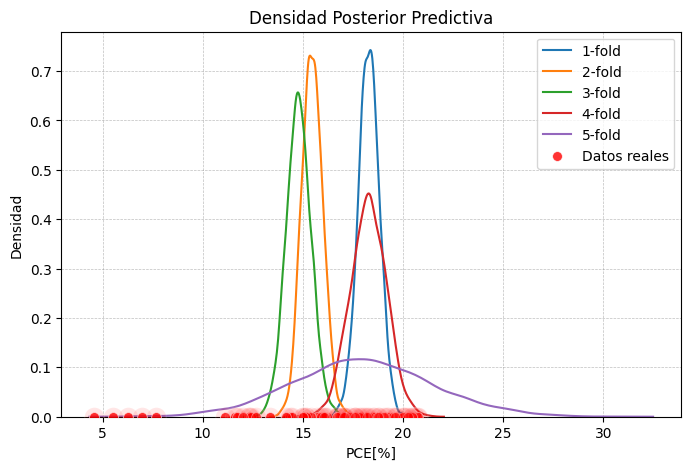

Voc


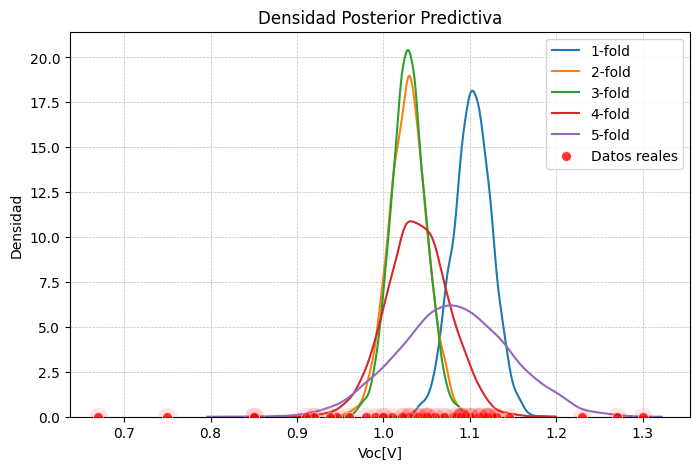

Jsc


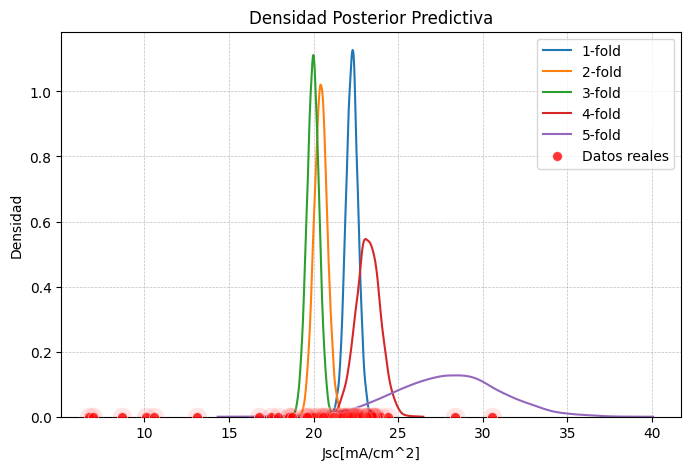

FF


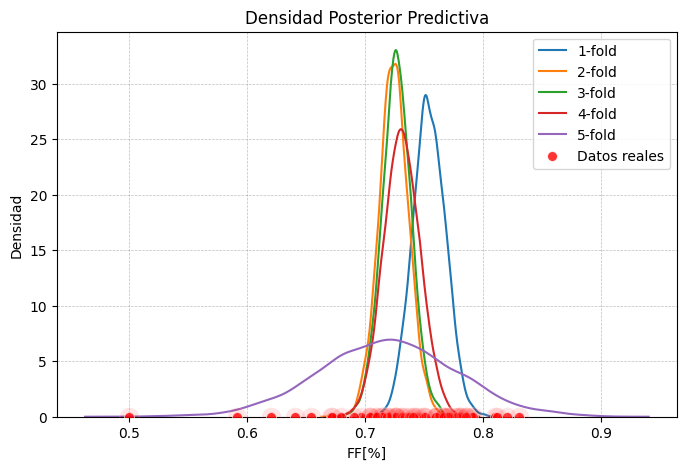

In [ ]:
# PDF de las predicciones (ejemplo)
ruta = '/content/drive/My Drive/Deep Learning/TG/Imagenes/Regression/DPP/'
for datos in data[data.columns[8:]]:
  print(datos)
  densidad_predicciones = []
  test = []
  predicciones_ = []
  for i in range(1,6):
    pdf_predicciones = prediccion[f"prediccion_{datos}"][f"fold_{i}"]
    densidad_prediccion = np.mean([pdf_predicciones[j] for j in range(len(data_test[f'data_test_{datos}'][f'test_fold_{i}']['y_test']))], axis=0)
    densidad_predicciones.append(densidad_prediccion)
    test.append(data_test[f'data_test_{datos}'][f'test_fold_{i}']['y_test'])
    predicciones_.append(pdf_predicciones)
  test = np.concatenate(test)
  densidad_predicciones = np.asarray(densidad_predicciones)
  #densidad_predicciones = np.mean([densidad_predicciones[j] for j in range(0,5)], axis = 0)

  # Crear el gráfico
  plt.figure(figsize=(8, 5))
  # Histograma de los datos de prueba
  for i in range(0,5):
    posterior_predictive = sns.kdeplot(densidad_predicciones[i], label = f'{i+1}-fold')
  sns.scatterplot(x=test, y=np.zeros_like(test), color='red', marker='o',s = 50, zorder=10, alpha = 0.8, label = "Datos reales")
  sns.scatterplot(x=test, y=np.zeros_like(test), color='r', marker='o',s = 200, alpha = 0.1, zorder=10)
  plt.xlabel(f"{datos}[{unidades[datos]}]")
  plt.ylabel('Densidad')
  plt.title(f'Densidad Posterior Predictiva')
  plt.grid(True, **grid_style)
  # Guarda la figura en un archivo (por ejemplo, en formato PNG) en la carpeta de Drive
  plt.savefig(ruta + f'{datos}.png')
  plt.show()


##Grafico del trazado para cada variable y cada modelo generado

In [ ]:
#for datos in data[data.columns[8:9]]:
#  print(datos)
#  for i in range(1,6):
#    idata = az.convert_to_inference_data(trazados_cargados[f'trace_{datos}'][f'trace_fold{i}']['posterior'])
#    print(datos, f'fold#{i}')
#    az.plot_trace(idata, var_names = ['A', "B", "X", "Band_gap"], kind = "trace", figsize=(10,10))
#    plt.tight_layout()
#    az.plot_trace(idata, var_names = ["DeltaH", "DeltaL",'Grain_size', "Thickness"], kind = "trace", figsize=(10,10))
#    plt.tight_layout()
#    az.plot_trace(idata, var_names = ["PCE", "Voc", "Jsc", "FF"], kind = "trace", figsize=(10,10))
#    plt.tight_layout()
#    plt.show()

<Figure size 800x500 with 0 Axes>

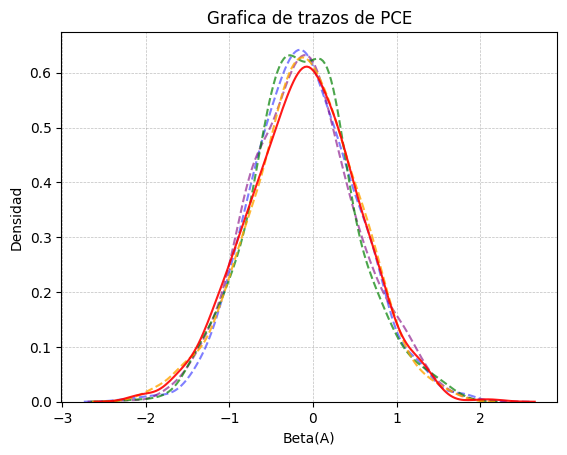

<Figure size 800x500 with 0 Axes>

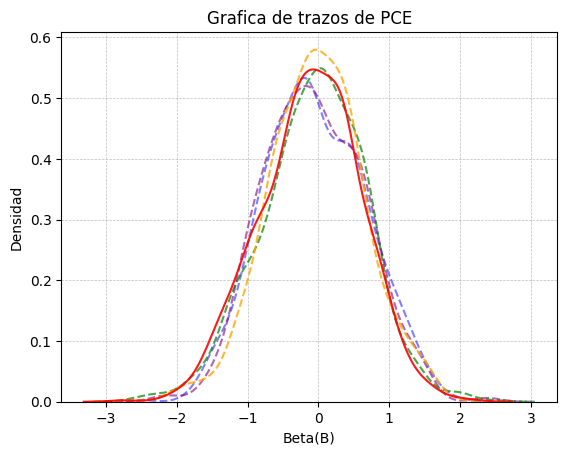

<Figure size 800x500 with 0 Axes>

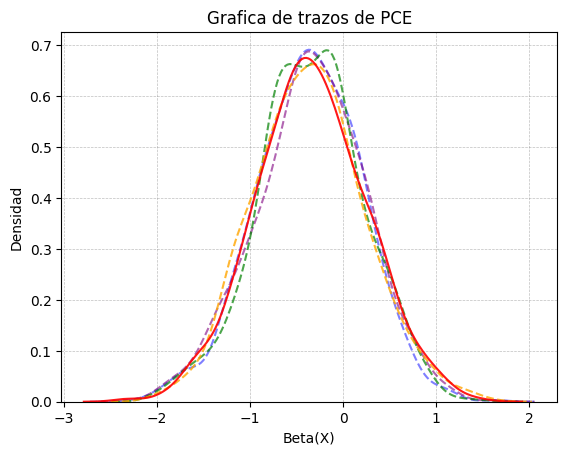

<Figure size 800x500 with 0 Axes>

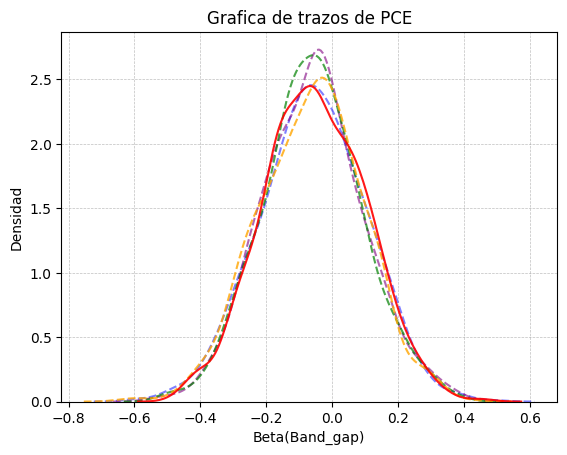

<Figure size 800x500 with 0 Axes>

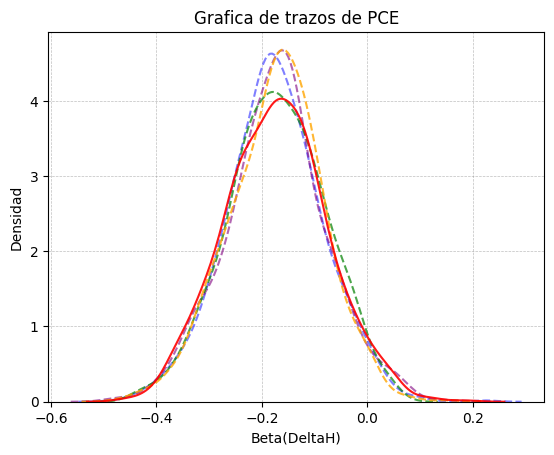

<Figure size 800x500 with 0 Axes>

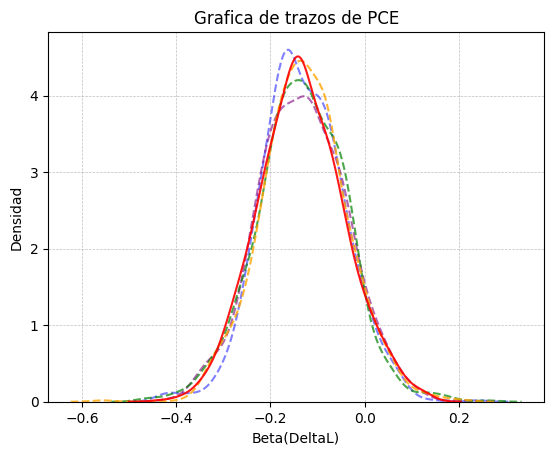

<Figure size 800x500 with 0 Axes>

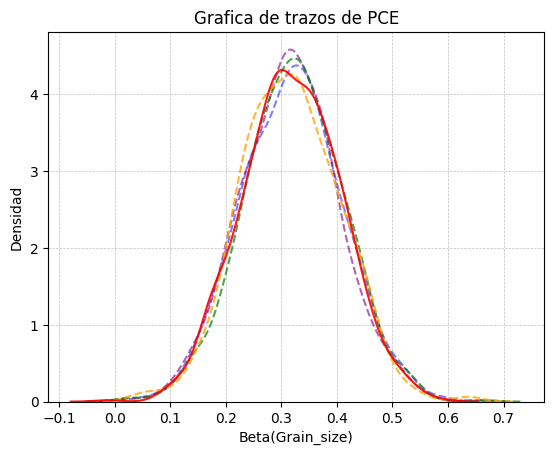

<Figure size 800x500 with 0 Axes>

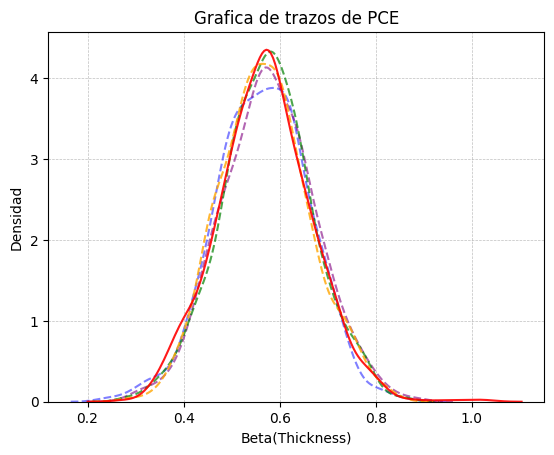

In [ ]:
#names = ['A','B','X', 'Band_gap', 'DeltaH', 'DeltaL', 'Grain_size', 'Thickness', "PCE", "Voc", "Jsc", "FF"]
grid_style = {'color': 'gray', 'linestyle': '--', 'linewidth': 0.5, 'alpha': 0.5}
estilo_linea = ["--", "--", "--", "--", "-"]
transparencia = [0.5, 0.6, 0.7, 0.8, 0.9]
colores = ['b', 'purple', 'g', 'orange', 'r']
for datos in data[data.columns[8:9]]:
  for i in range(5,6):
    for name in names:
      plt.figure(figsize=(8, 5))
      fig, ax = plt.subplots()
      for j in range (0,5):
        sns.kdeplot(trazados_cargados[f'trace_{datos}'][f'trace_fold{i}']['posterior'][name][j], linestyle=estilo_linea[j], alpha = transparencia[j], color = colores[j])
        plt.title(f"Grafica de trazos de {datos}")
        plt.ylabel("Densidad")
        plt.xlabel(f"Beta({name})")
        plt.grid(True, **grid_style)
        ruta = '/content/drive/My Drive/Deep Learning/TG/Imagenes/Regression/SAMPLEO/'
        plt.savefig(ruta + f'trazos_{datos}_{name}.png')
      plt.show()